In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np

from salishsea_tools.nc_tools import scDataset

%matplotlib inline

# Extract variables and plot

In [2]:
def get_parent_files(dirname, grid):
    '''from analysis-michael/raw/tip/notebooks/FraserFlow.ipynb
    '''
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, "MCKNZ_1h_20170101_20170120_*"+grid+"*.nc"):
            files += [os.path.join(dirname,item)]
    return files

def get_child_files(dirname, grid):
    '''from analysis-michael/raw/tip/notebooks/FraserFlow.ipynb
    '''
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, "1_MCKNZ_1h_20170101_20170120_*"+grid+"*.nc"):
            files += [os.path.join(dirname,item)]
    return files

def get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc):
    time_ind = 300

    with scDataset(filesTp) as ds:
        temp_parent = ds.variables['votemper'][time_ind, dep_ind,:,:]
        nav_lat_parent = ds.variables['nav_lat'][:]
        nav_lon_parent = ds.variables['nav_lon'][:]

    with scDataset(filesUp) as ds:
        u_parent = ds.variables['vozocrtx'][time_ind, dep_ind,:,:]

    with scDataset(filesTc) as ds:
        temp_child = ds.variables['votemper'][time_ind, dep_ind,:,:]
        nav_lat_child = ds.variables['nav_lat'][:]
        nav_lon_child = ds.variables['nav_lon'][:]

    with scDataset(filesUc) as ds:
        u_child = ds.variables['vozocrtx'][time_ind, dep_ind,:,:]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as nbl:
        tmask = nbl.variables['tmask'][0,dep_ind,:,:]
        umask = nbl.variables['umask'][0,dep_ind,:,:]

    temp_child = np.ma.array(temp_child, mask=1 - tmask)
    u_child = np.ma.array(u_child, mask=1 - umask)
    
    return temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child

In [3]:
def make_plot(var_parent, var_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, vmin, vmax, ttl):
    s = slice(1,-1,None)
    fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(20, 15))
    cmap = plt.get_cmap(cm.Paired_r)
    cmap.set_bad('wheat')

    plt.tight_layout(h_pad=5, w_pad=3)
    plt.suptitle(ttl, fontsize=20)
    plt.subplots_adjust(top=0.90)
    
    p1 = ax1.pcolormesh(var_parent, vmin=vmin, vmax=vmax, cmap=cmap)
    p2 = ax2.pcolormesh(var_child, vmin=vmin, vmax=vmax, cmap=cmap)
  
    p3 = ax3.pcolormesh(nav_lon_parent[s,s], nav_lat_parent[s,s], var_parent[s,s], vmin=vmin, vmax=vmax, cmap=cmap)
    ax3.scatter(nav_lon_child[::10, ::10], nav_lat_child[::10, ::10], alpha=0.2, c='k')
    
    p4 = ax4.pcolormesh(nav_lon_parent[s,s], nav_lat_parent[s,s], var_parent[s,s], vmin=vmin, vmax=vmax, cmap=cmap)
    ax4.pcolormesh(nav_lon_child[s,s], nav_lat_child[s,s], var_child[s,s], vmin=vmin, vmax=vmax, cmap=cmap)

    ax1.set_title('parent', fontsize=20)
    ax2.set_title('child', fontsize=20)
    ax3.set_title('parent with child coordinates', fontsize=20)
    ax4.set_title('parent AND child', fontsize=20)
    
    ax1.set_xlim([0,var_parent.shape[1]]); ax1.set_ylim([0,var_parent.shape[0]])
    ax2.set_xlim([0,var_child.shape[1]]); ax2.set_ylim([0,var_child.shape[0]])

    for p, ax in zip([p1, p2, p3, p4], [ax1, ax2, ax3, ax4]):
        cbar = fig.colorbar(p, ax=ax)
        if ax==ax3 or ax==ax4:
            ax.set_xlim([nav_lon_parent[s,s].min(), nav_lon_parent[s,s].max()])
            ax.set_ylim([nav_lat_parent[s,s].min(), nav_lat_parent[s,s].max()])
            ax.set_xlabel('longitude', fontsize=15); ax.set_ylabel('latitude', fontsize=15)
        if ax==ax1 or ax==ax2:
            ax.set_xlabel('x indices', fontsize=15); ax.set_ylabel('y indices', fontsize=15)
        #if ax==ax2 or ax==ax4:
        #    ax.set_axis_bgcolor('wheat')
    return fig

# At the surface
### 1. Ideal using dynspg_ts

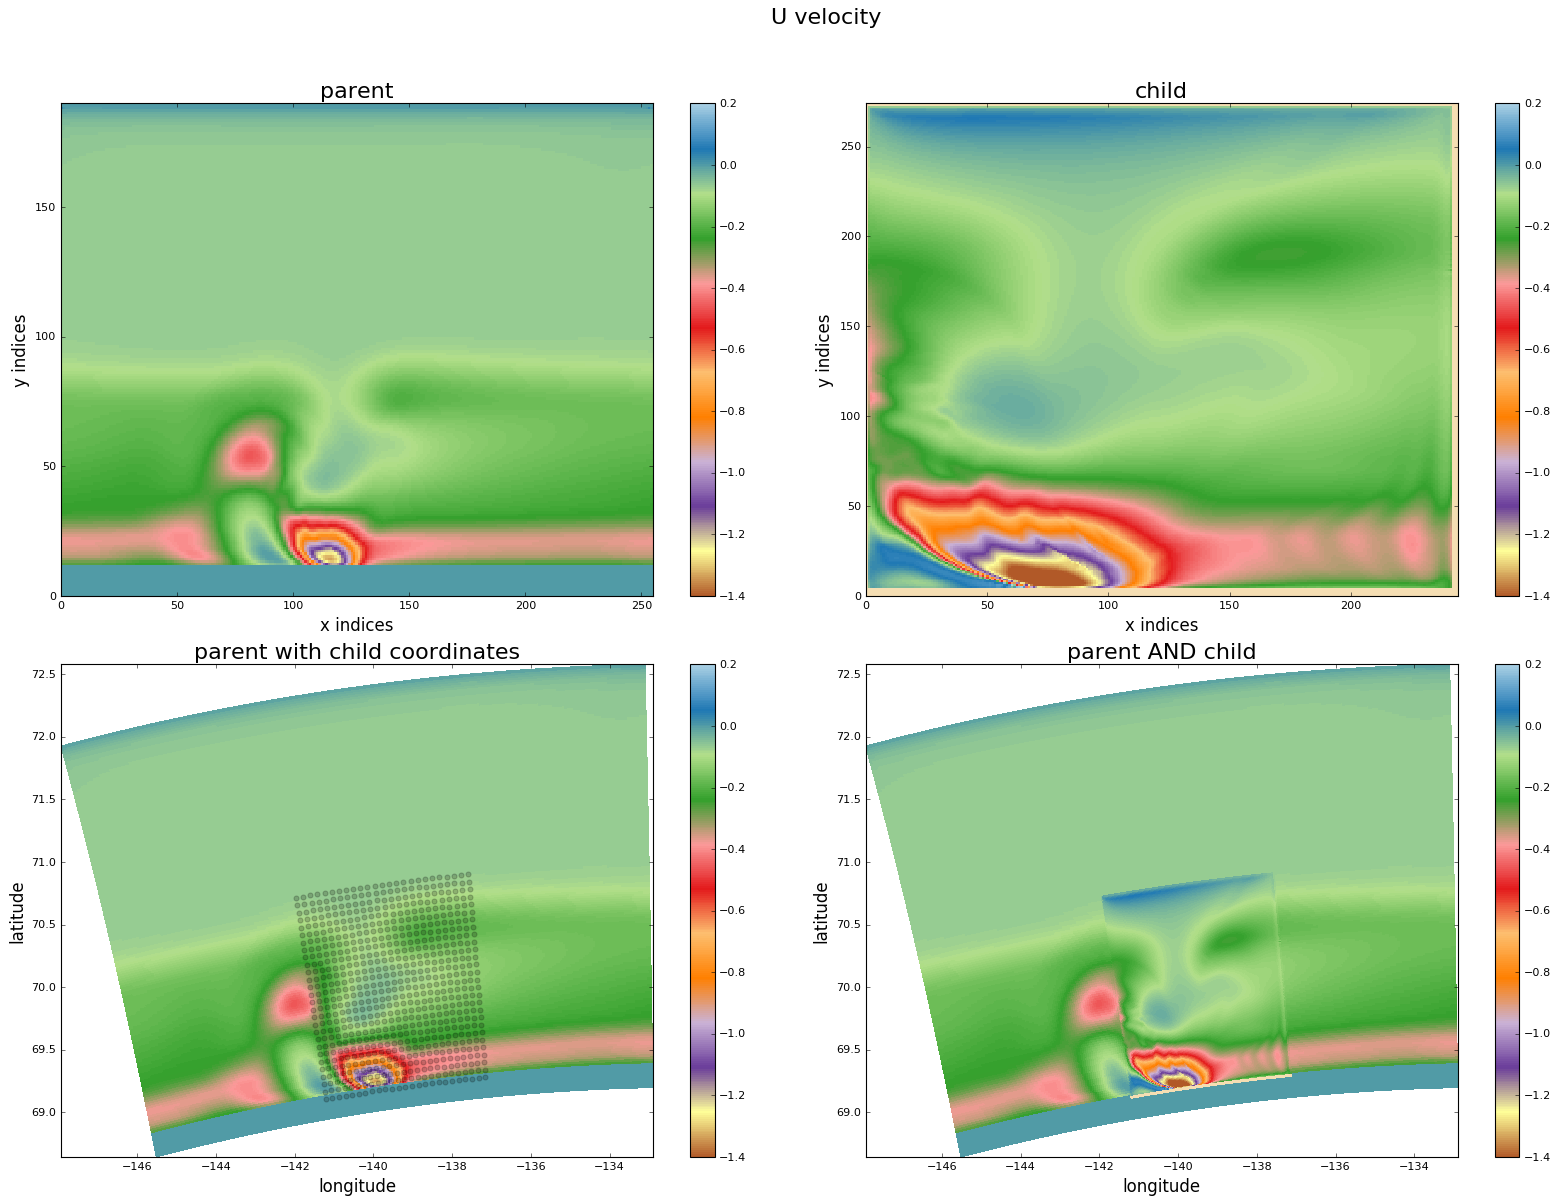

In [23]:
dirname='/home/mdunphy/Canyons/Results/Ideal4/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)


dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 1.3, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.4, 0.2, ttl)

### 2. Ideal using dynspg_flt

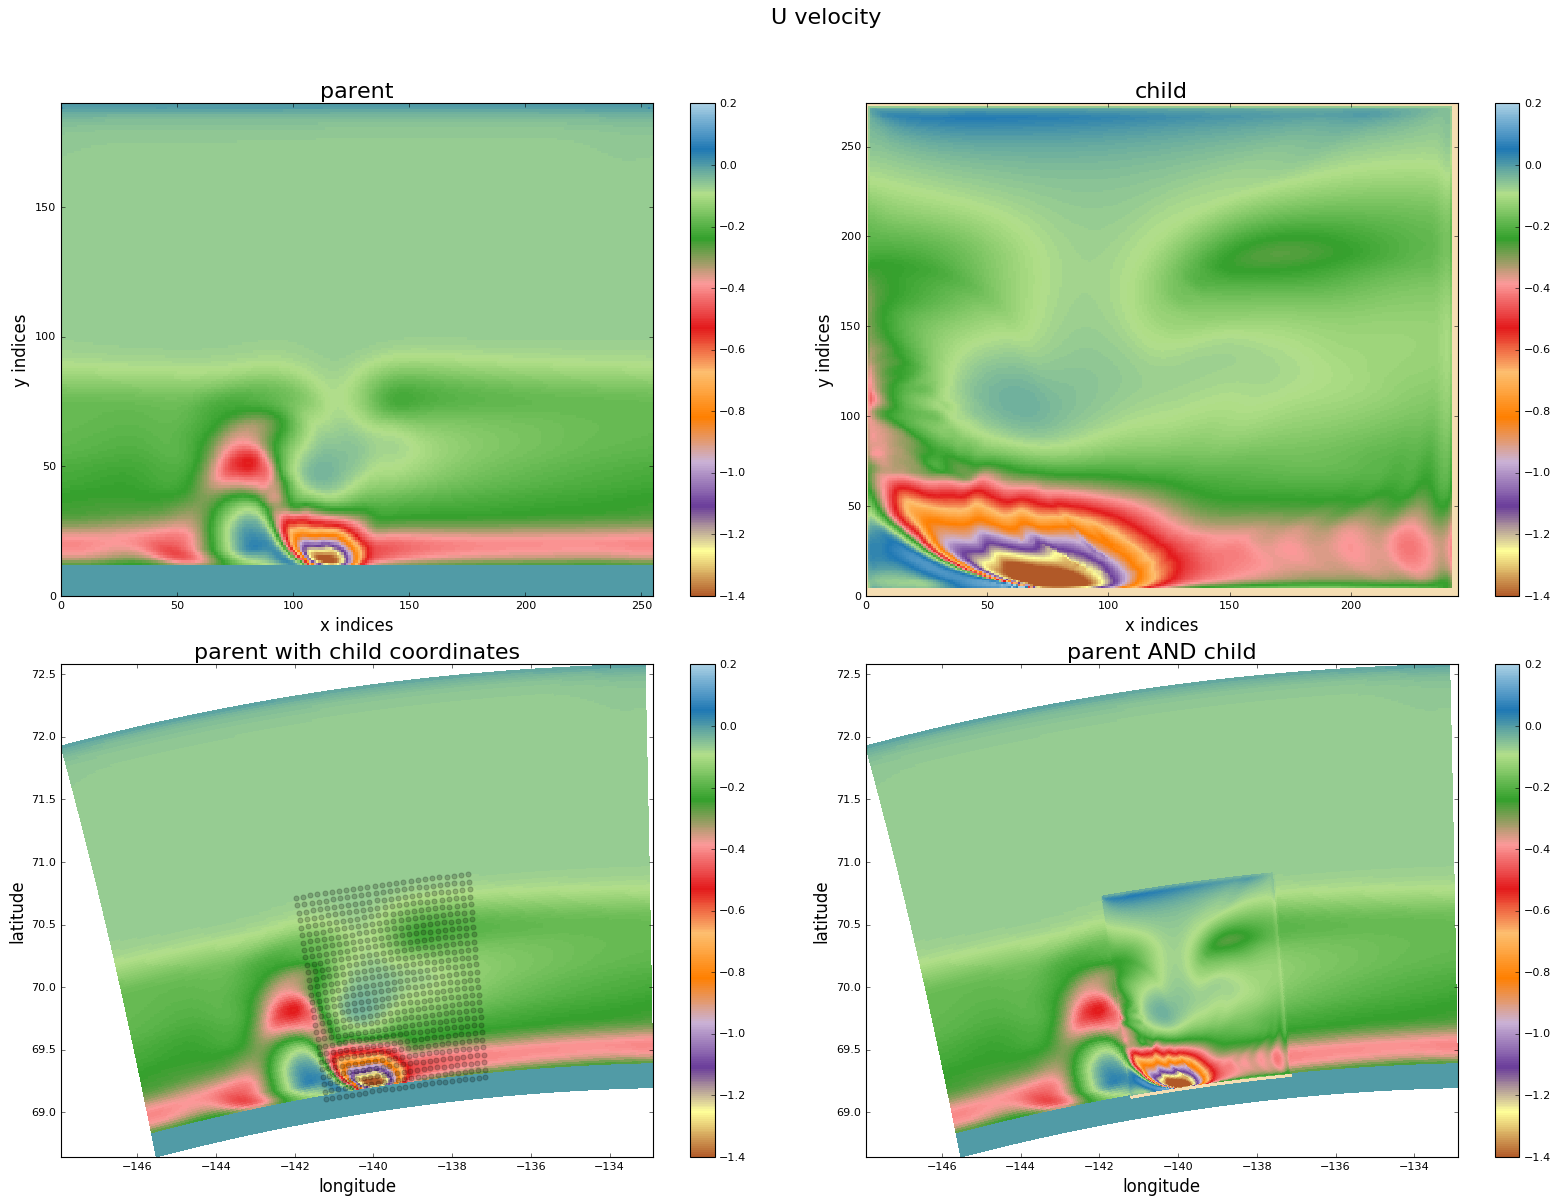

In [24]:
dirname='/home/mdunphy/Canyons/Results/Ideal4flt/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 1.3, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.4, 0.2, ttl)

### 3. Real using dynspg_ts

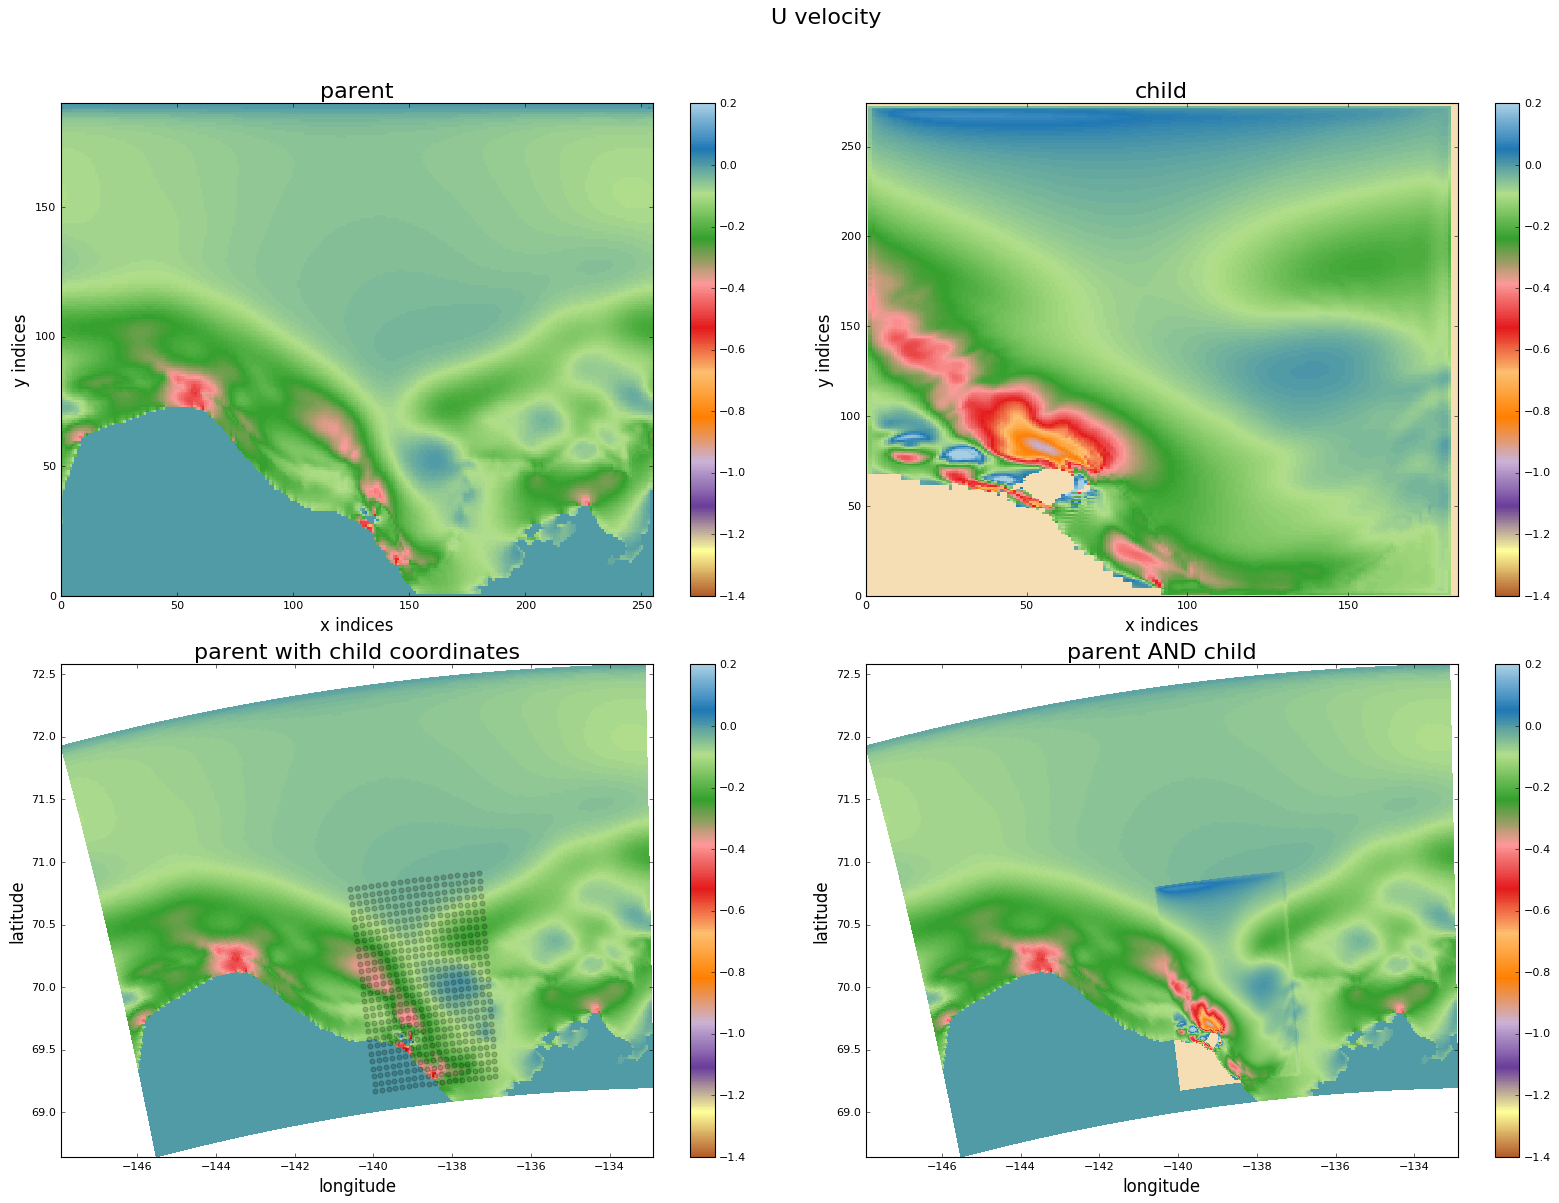

In [25]:
dirname='/home/mdunphy/Canyons/Results/Real4/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 1.3, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.4, 0.2, ttl)

# At shelf break depth (ind=9, gdept=83.125)

### 1. Ideal using dynspg_ts

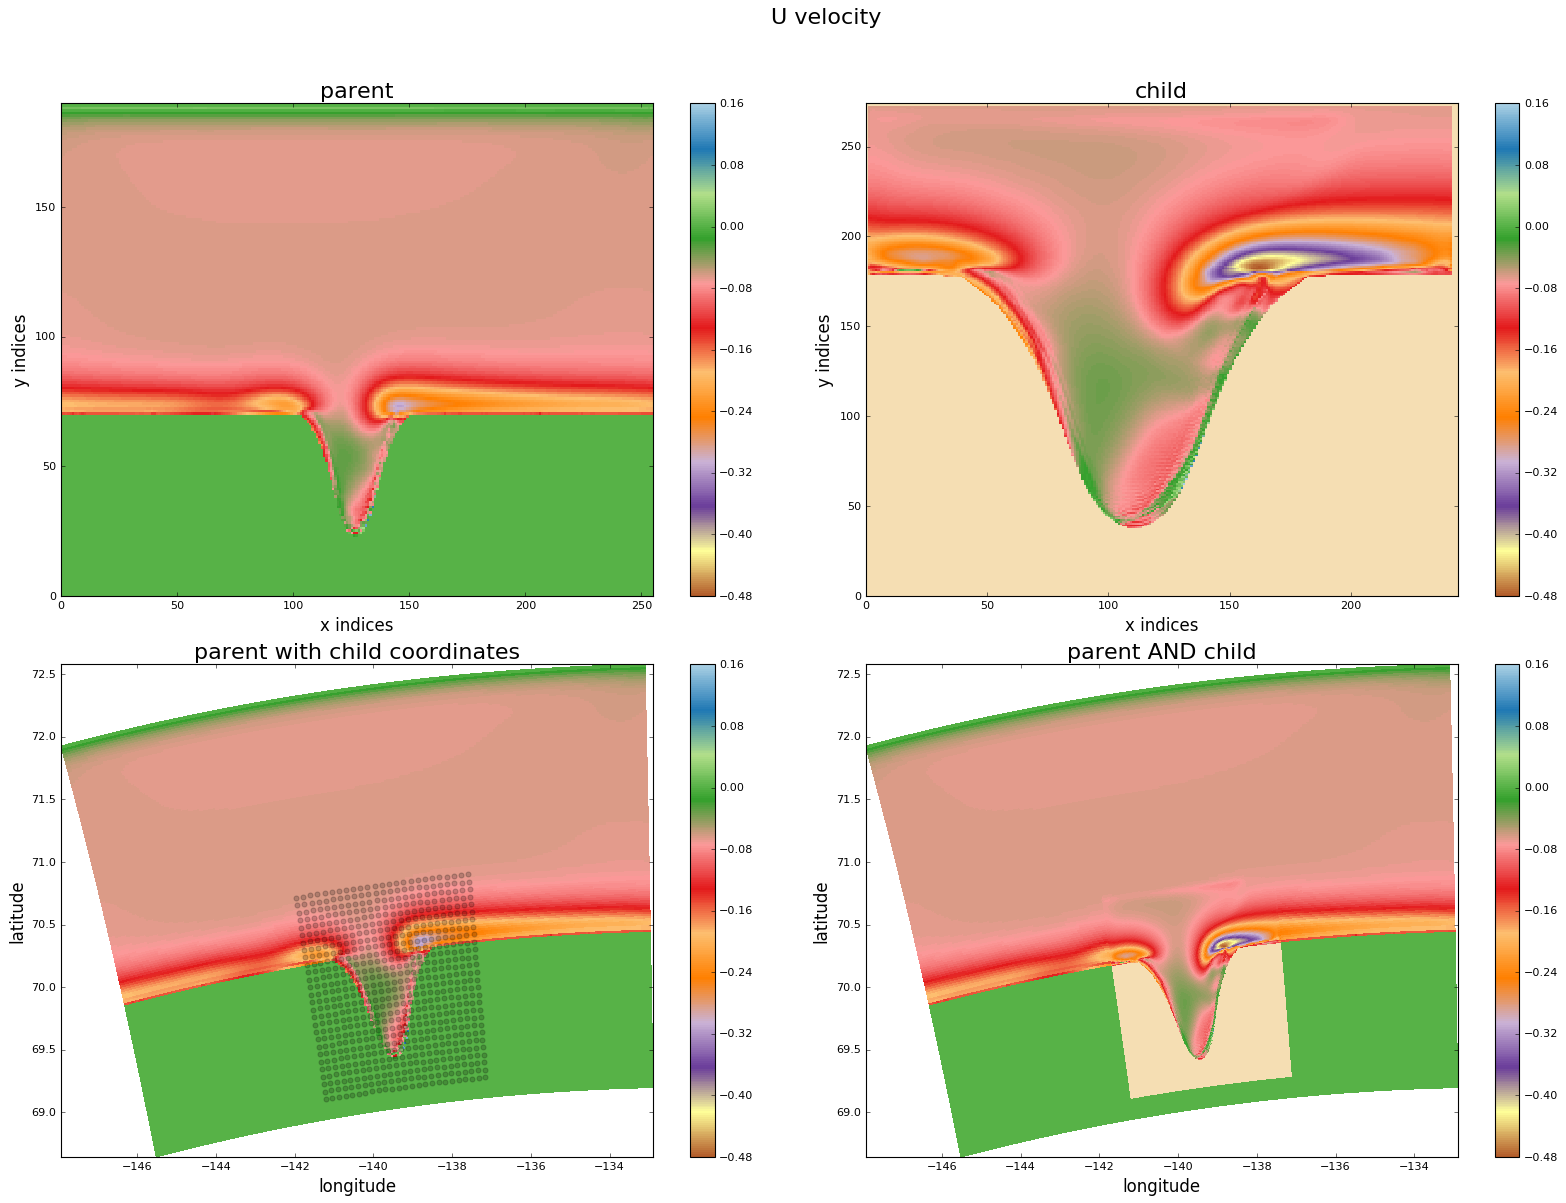

In [26]:
dirname='/home/mdunphy/Canyons/Results/Ideal4/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -2.0, 0.8, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.48, 0.16, ttl)

### 2. Ideal using dynspg_flt

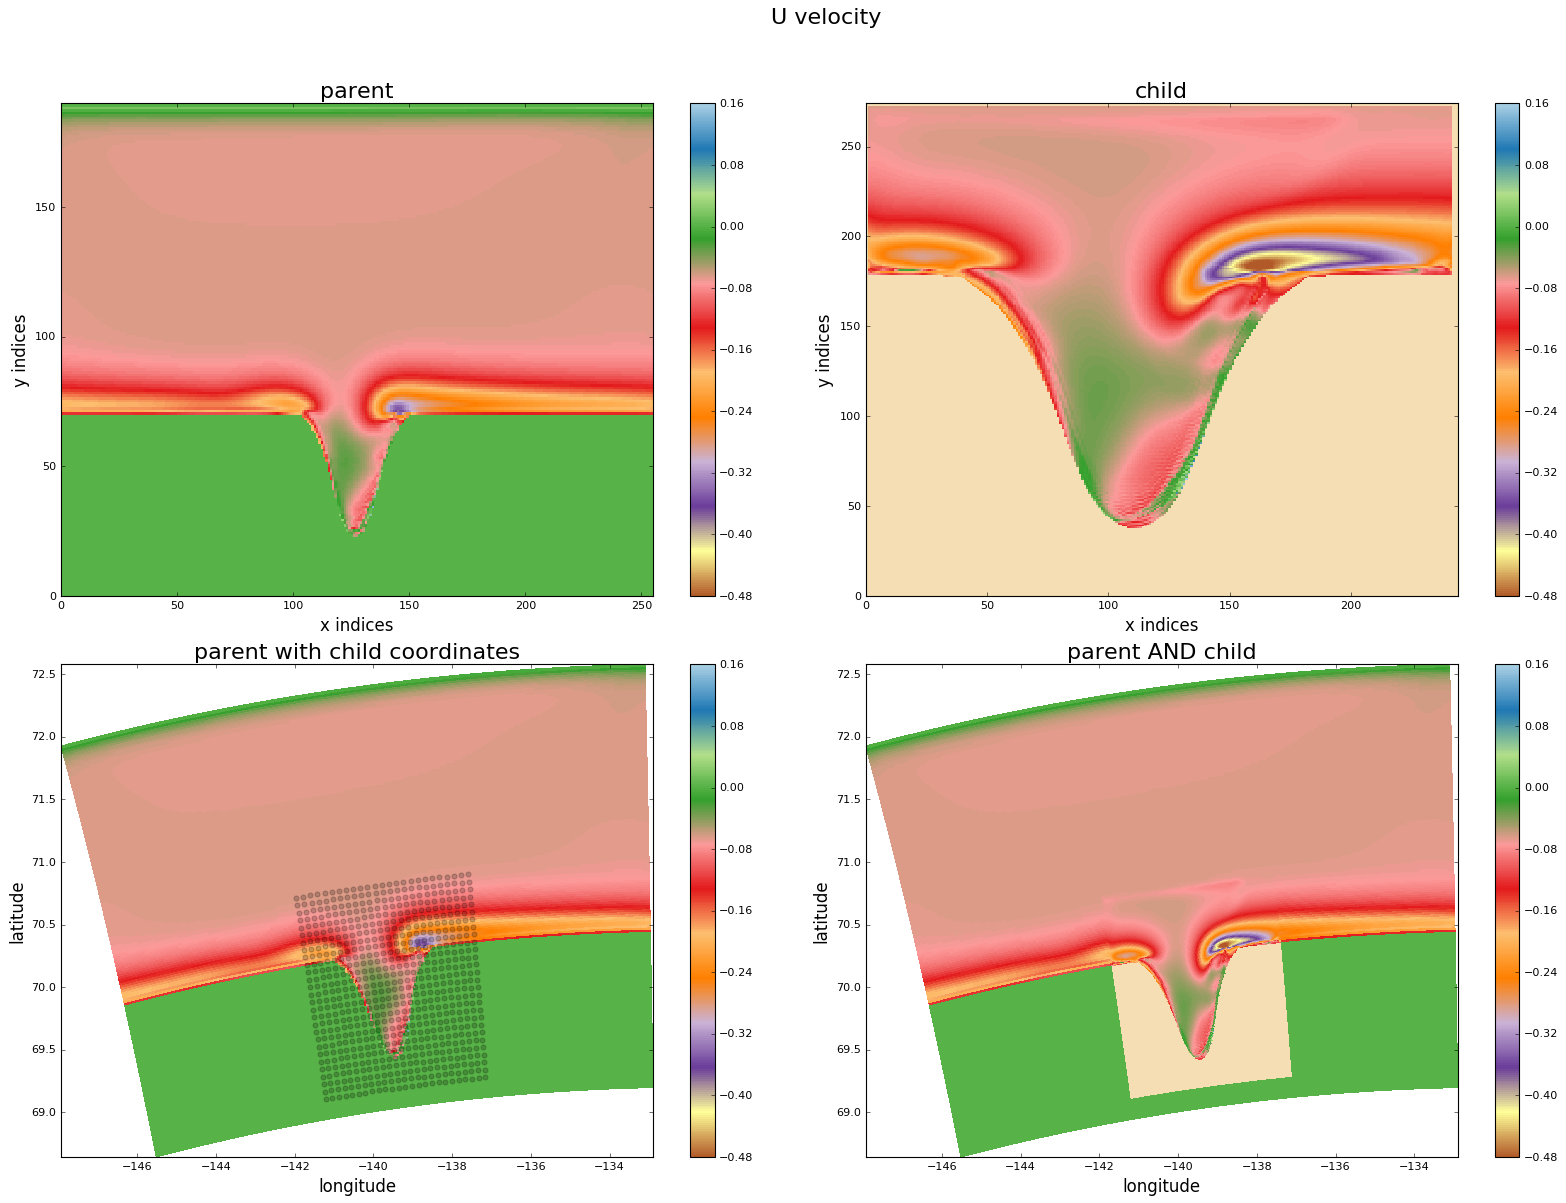

In [27]:
dirname='/home/mdunphy/Canyons/Results/Ideal4flt/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -2.0, 0.8, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.48, 0.16, ttl)

### 3. Real using dynspg_ts

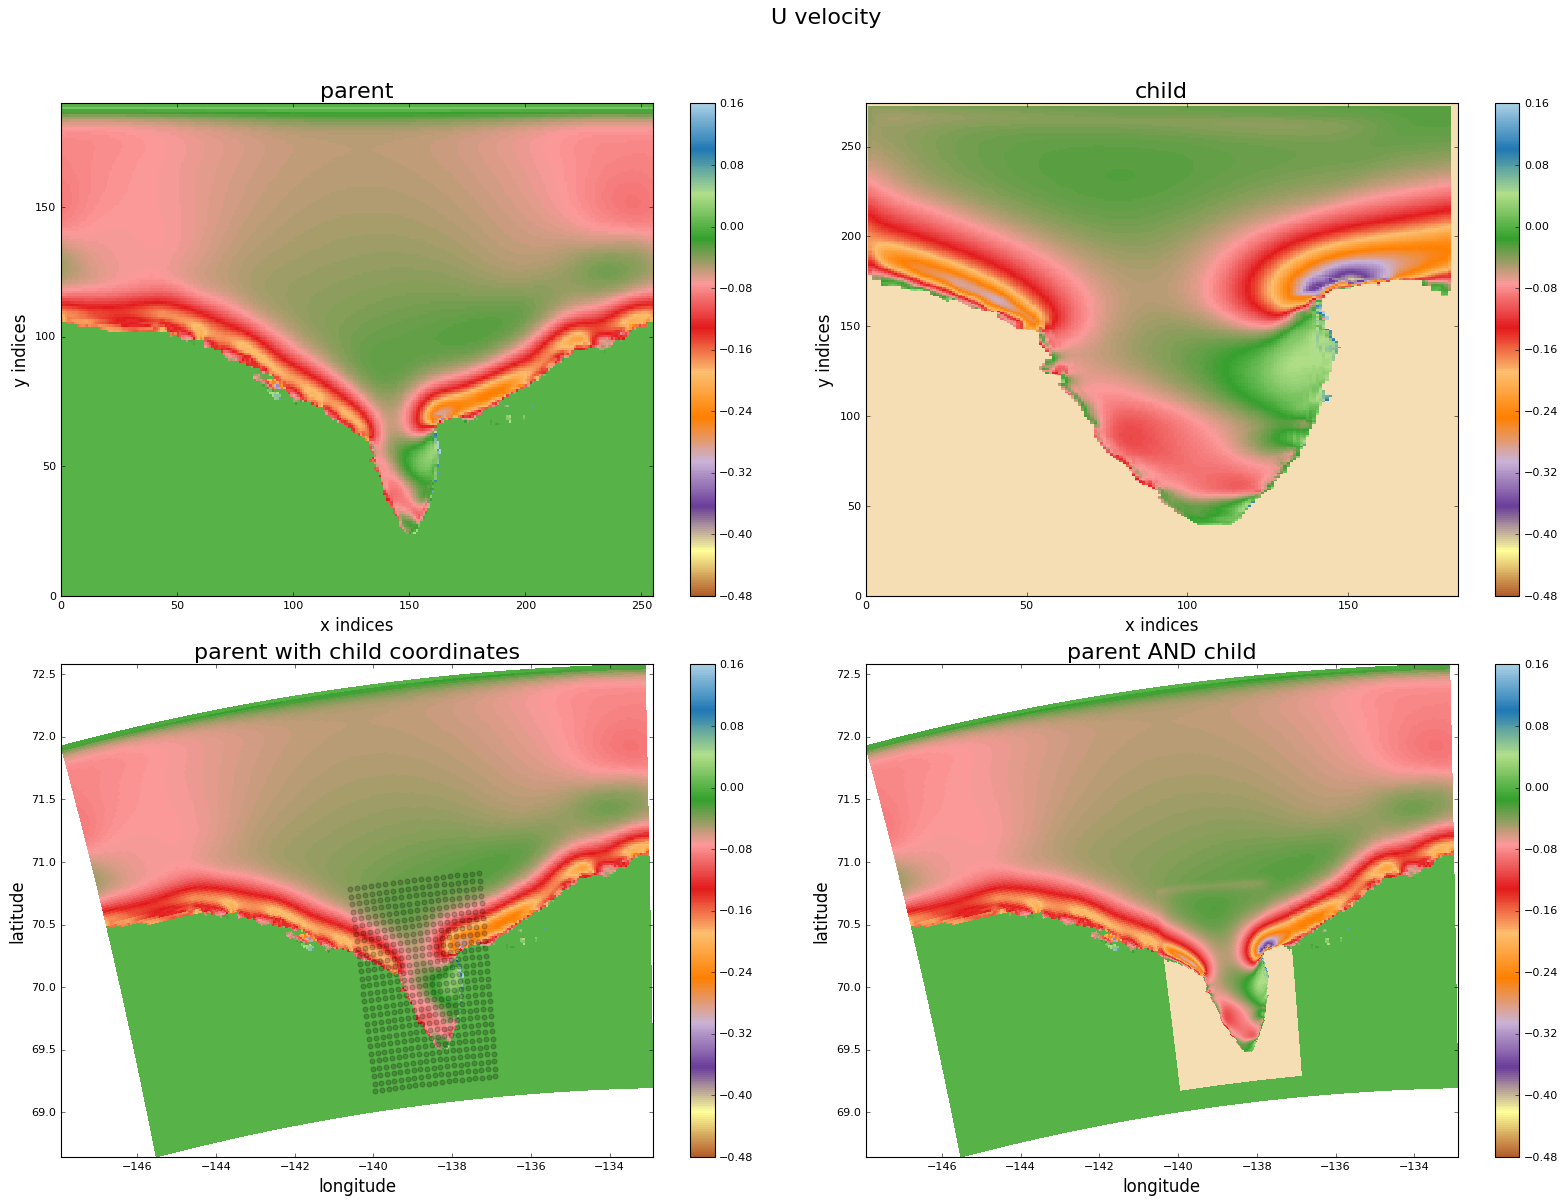

In [28]:
dirname='/home/mdunphy/Canyons/Results/Real4/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -2.0, 0.8, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.48, 0.16, ttl)

# Two-Way

### 1. Ideal Surface

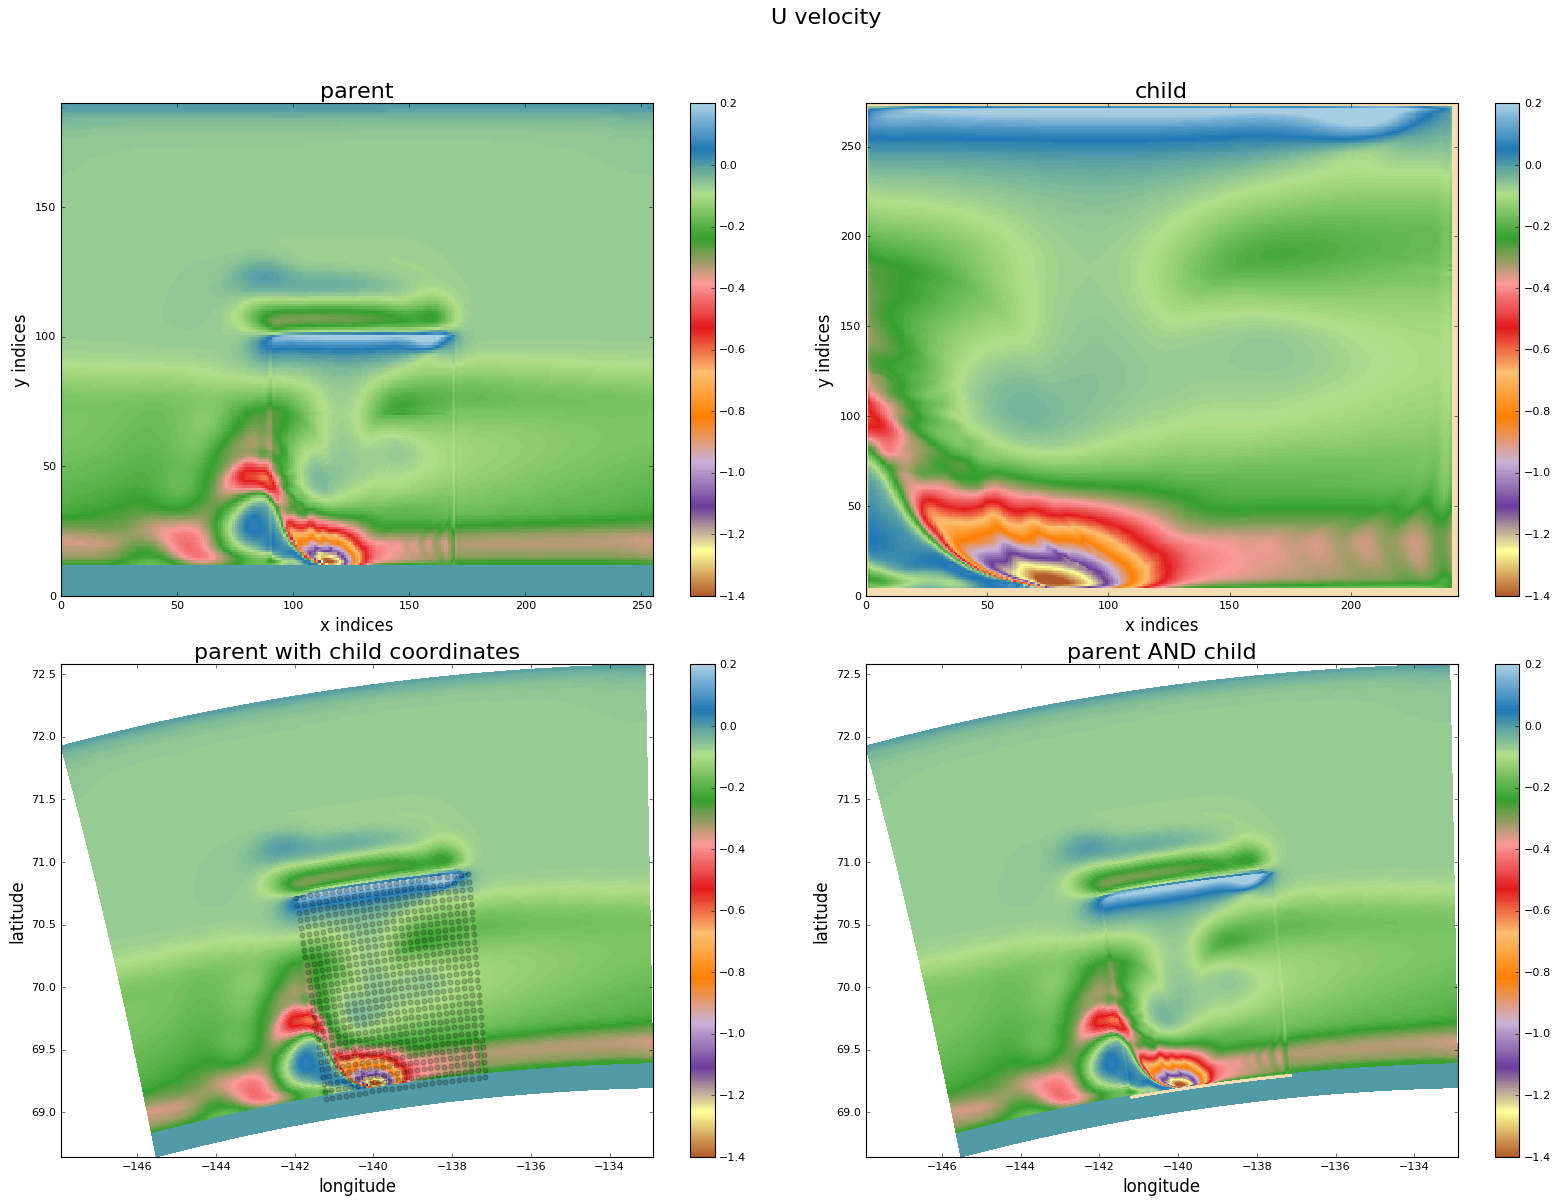

In [29]:
dirname='/home/mdunphy/Canyons/Results/Ideal4T'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 1.3, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.4, 0.2, ttl)

### 2. Ideal Depth

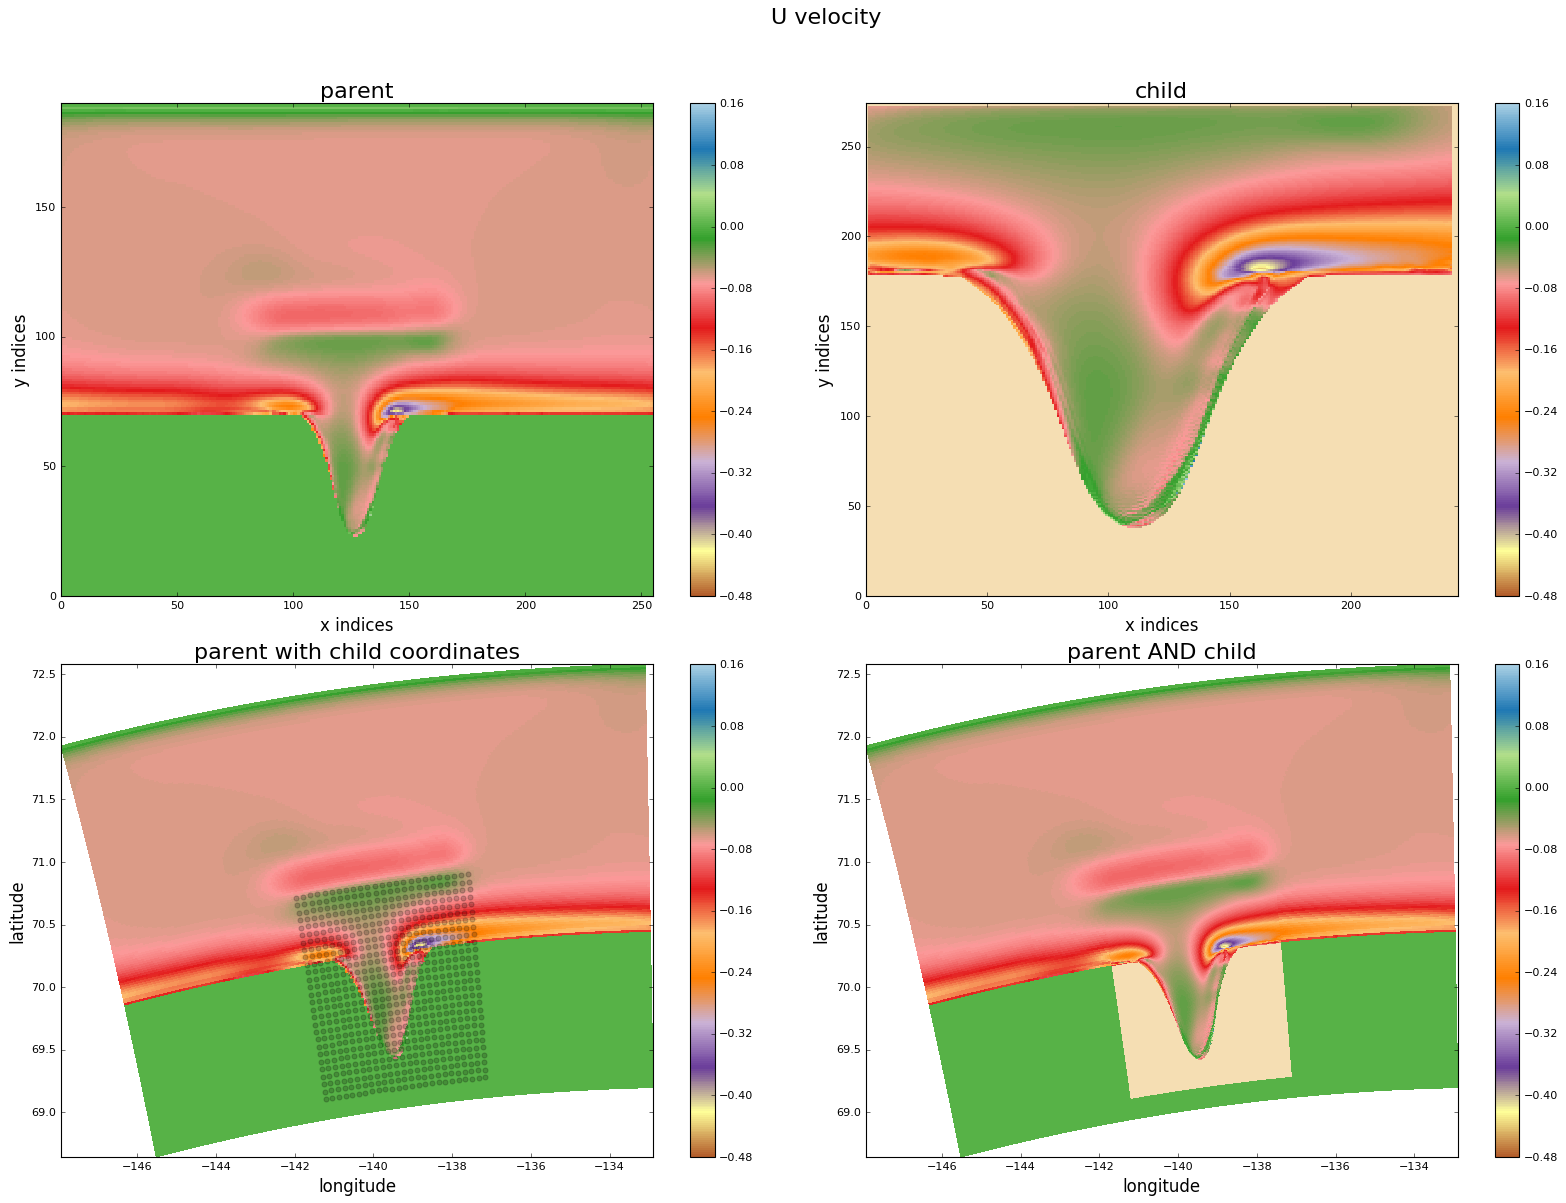

In [30]:
dirname='/home/mdunphy/Canyons/Results/Ideal4T'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -2.0, 0.8, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.48, 0.16, ttl)

### 3. Real Surface

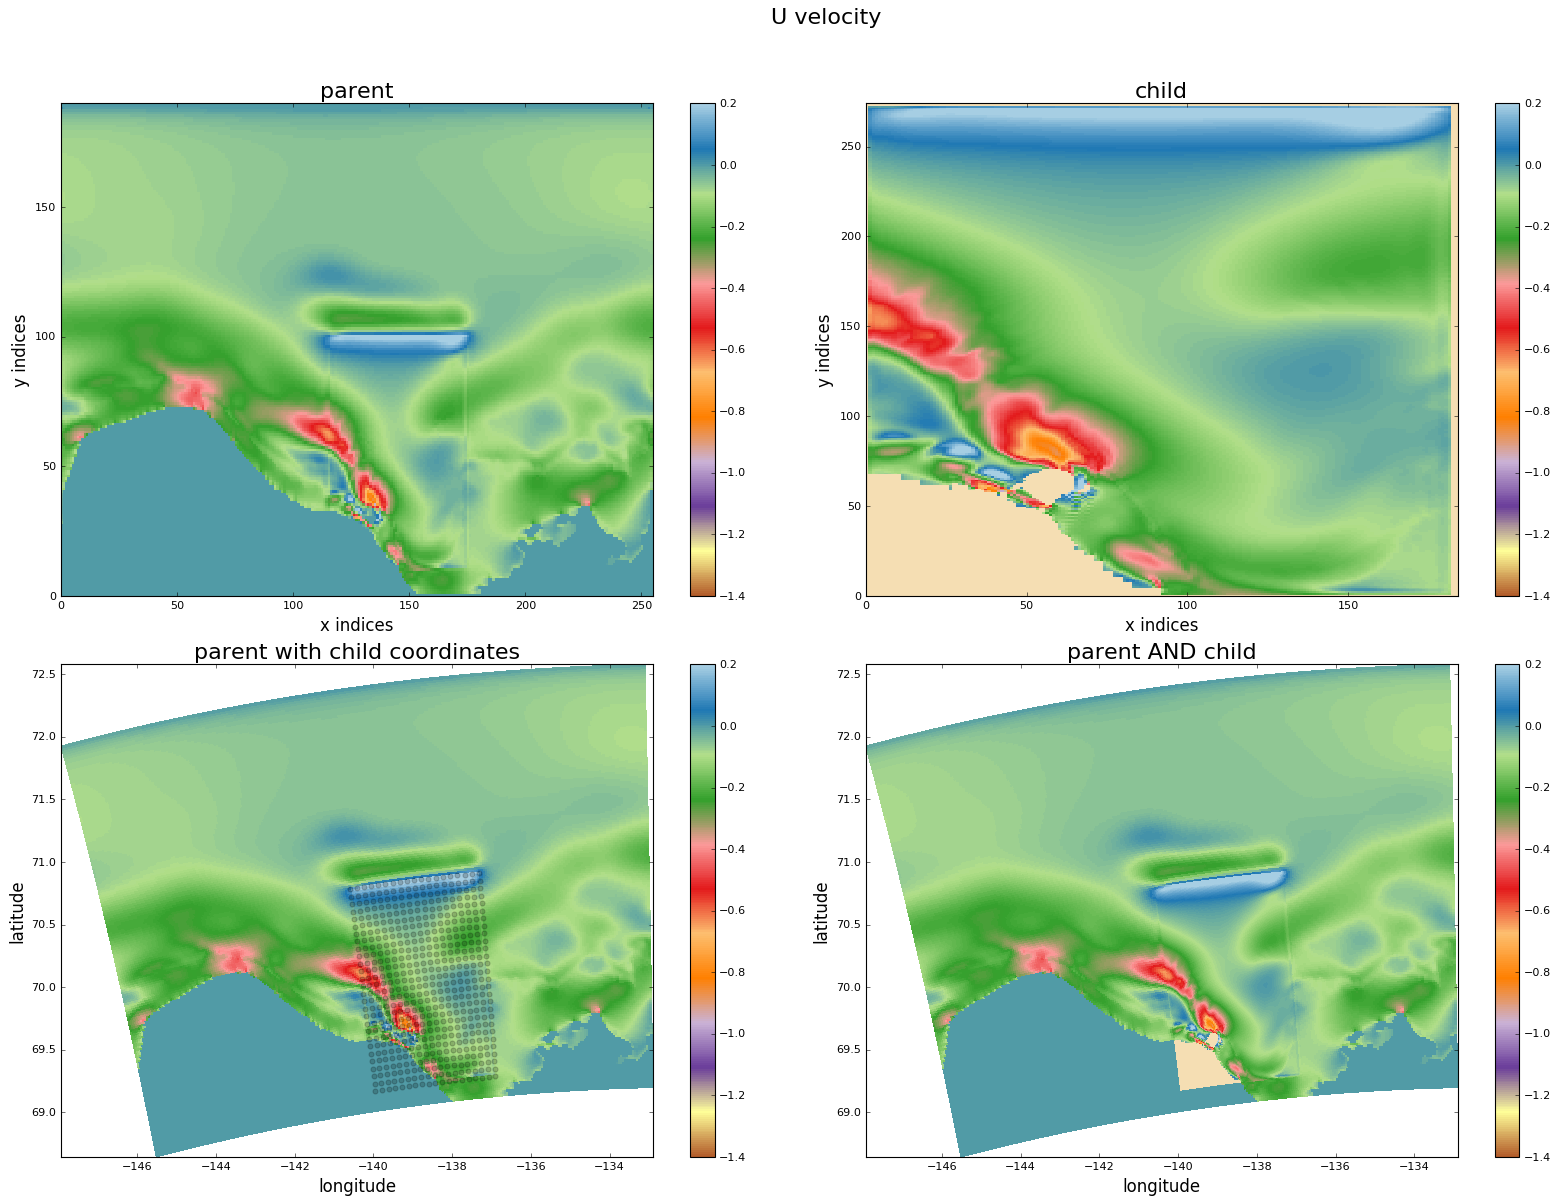

In [31]:
dirname='/home/mdunphy/Canyons/Results/Real4T/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 1.3, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.4, 0.2, ttl)

### 4. Real Depth

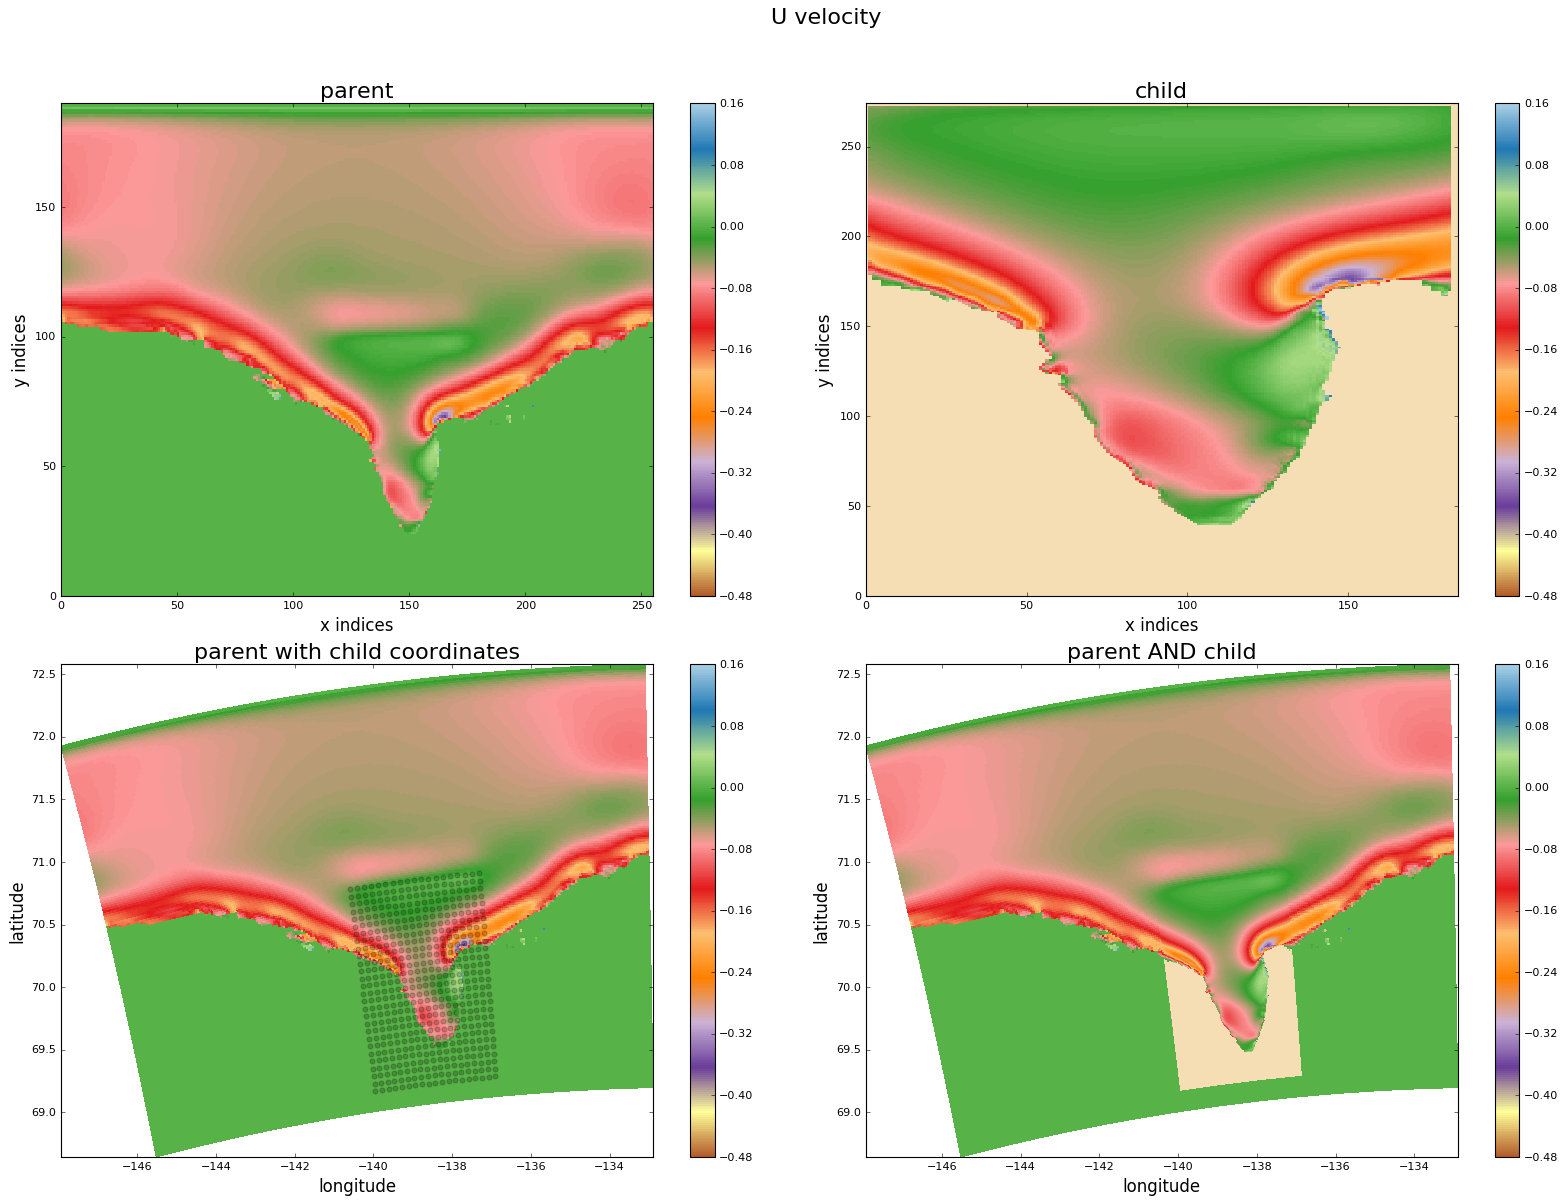

In [32]:
dirname='/home/mdunphy/Canyons/Results/Real4T/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

#ttl = 'Temperature'
#figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -2.0, 0.8, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.48, 0.16, ttl)

# Two-way Adjustments

### 1. Ideal Surface

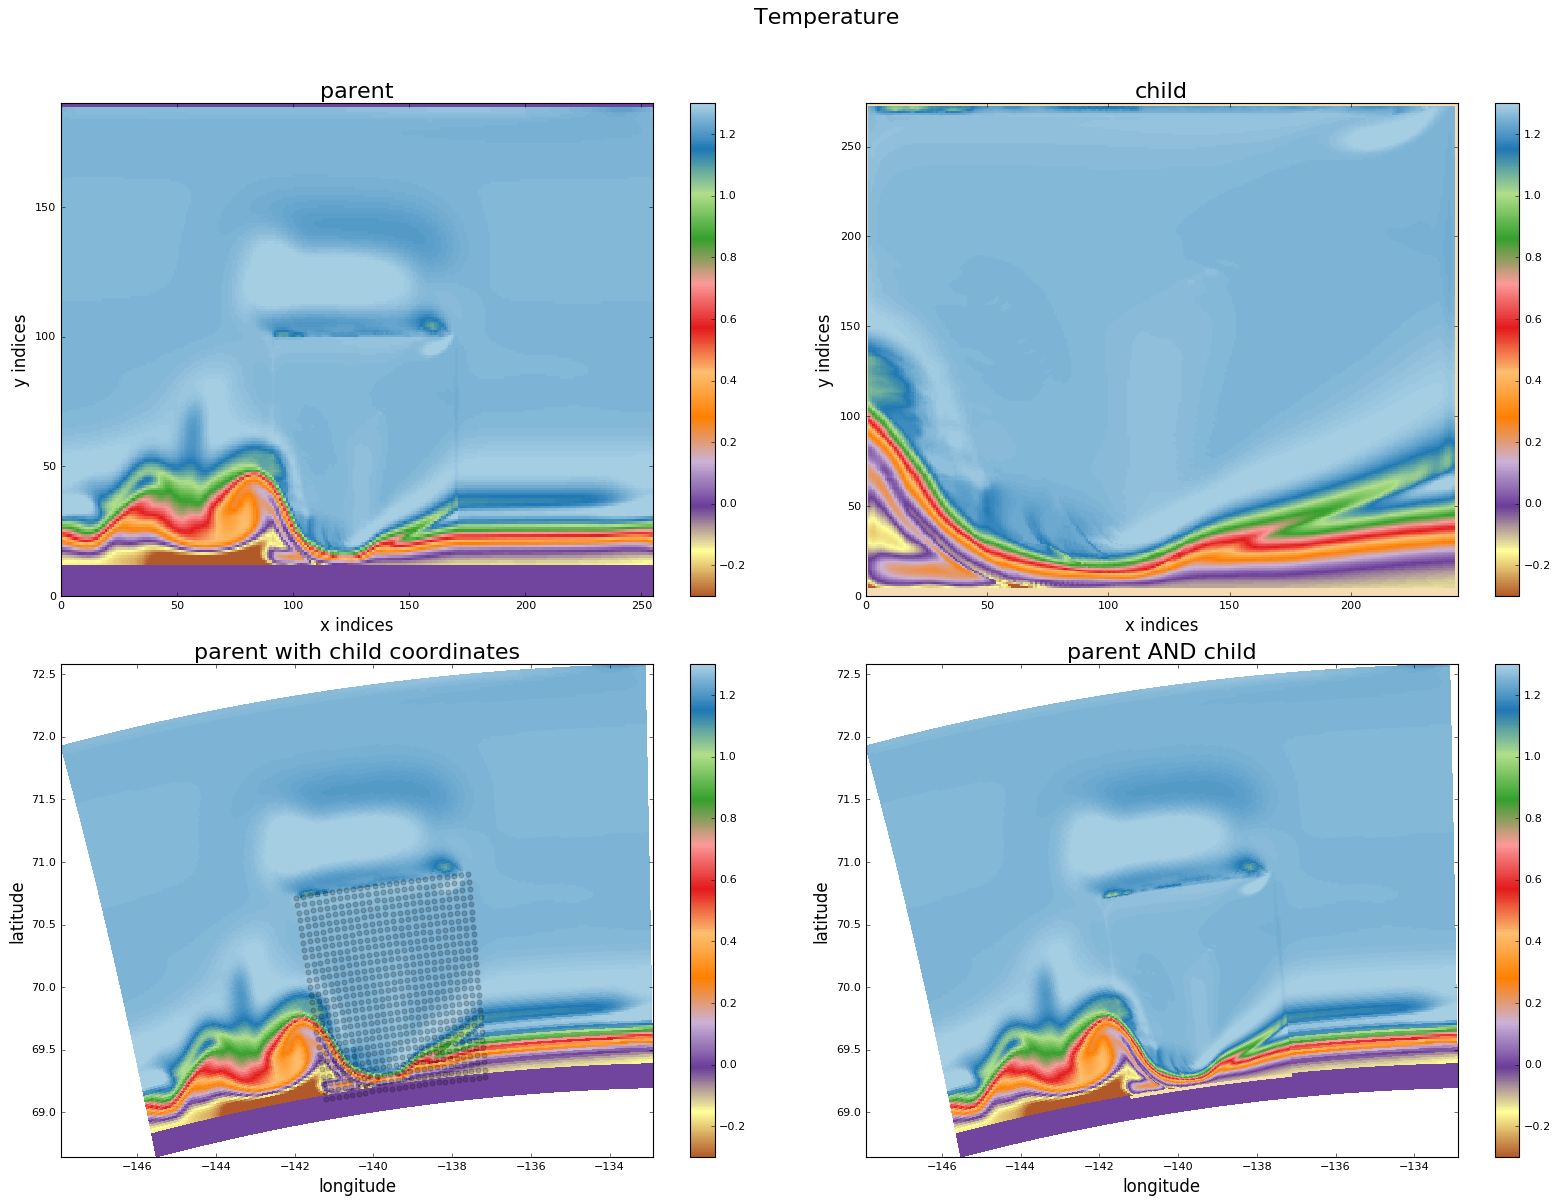

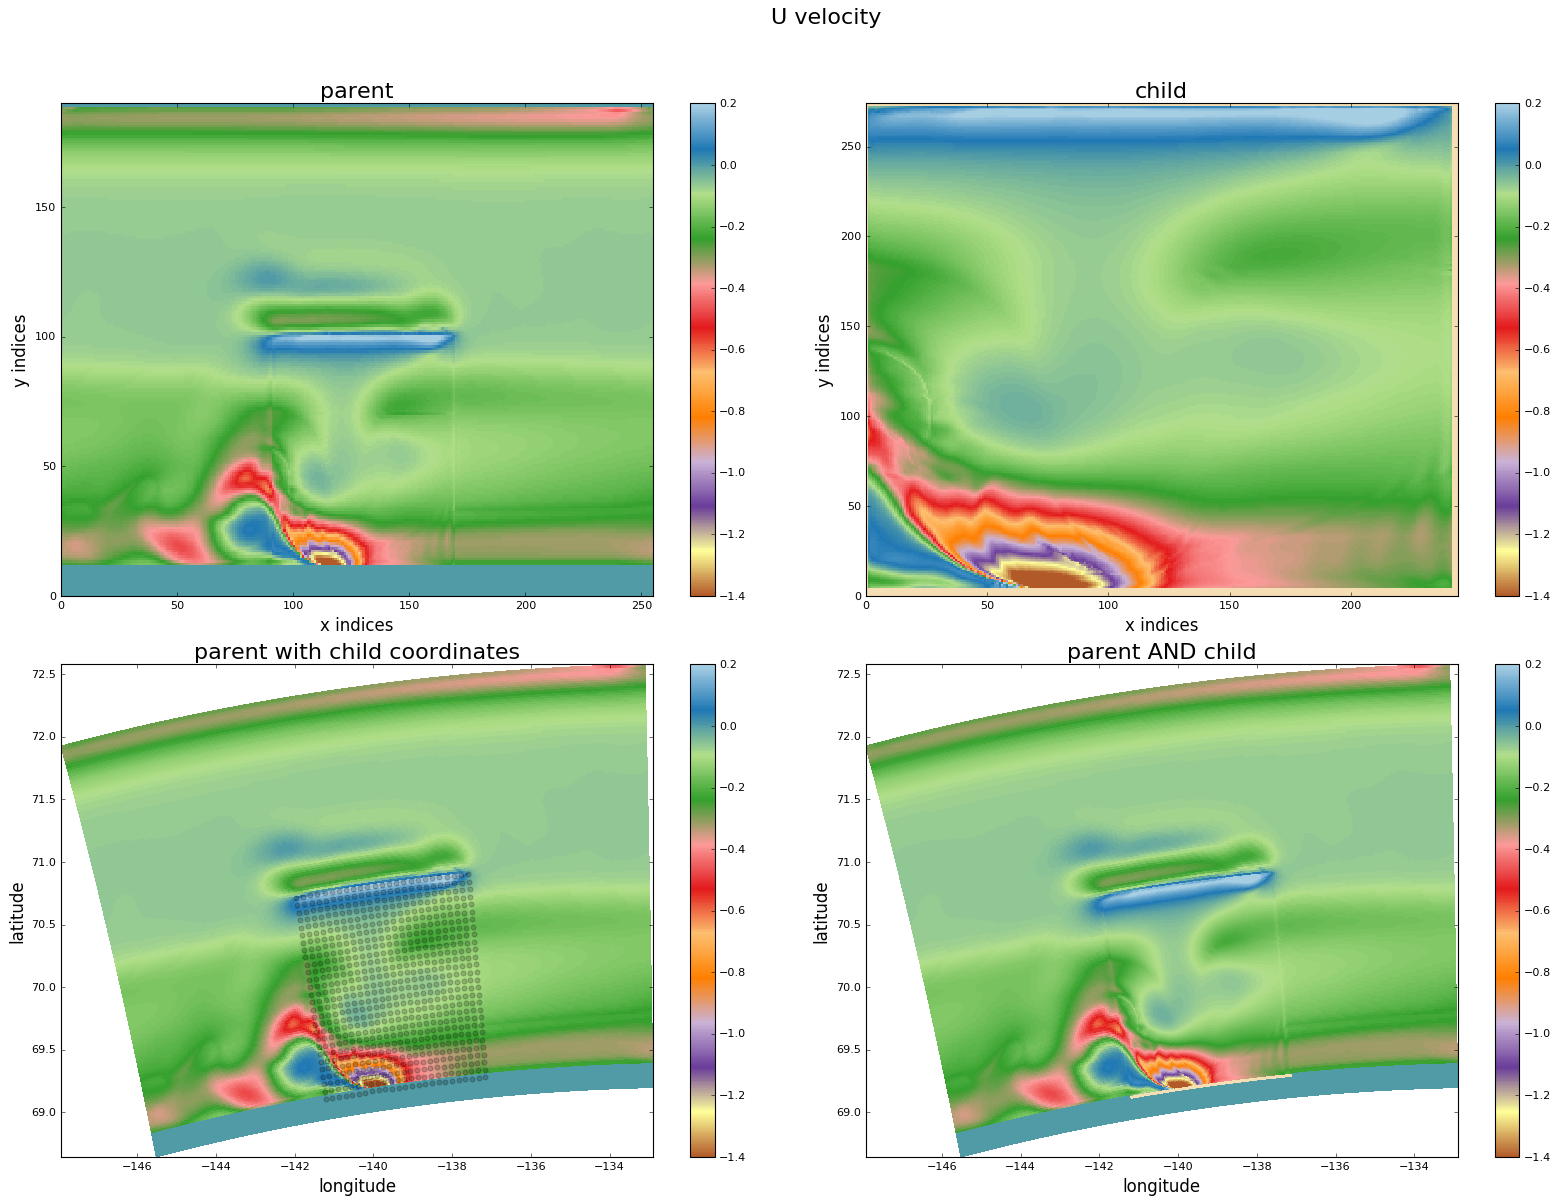

In [14]:
dirname='/home/mdunphy/Canyons/Results/Ideal4T2/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

ttl = 'Temperature'
figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 1.3, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.4, 0.2, ttl)

### Ideal Depth

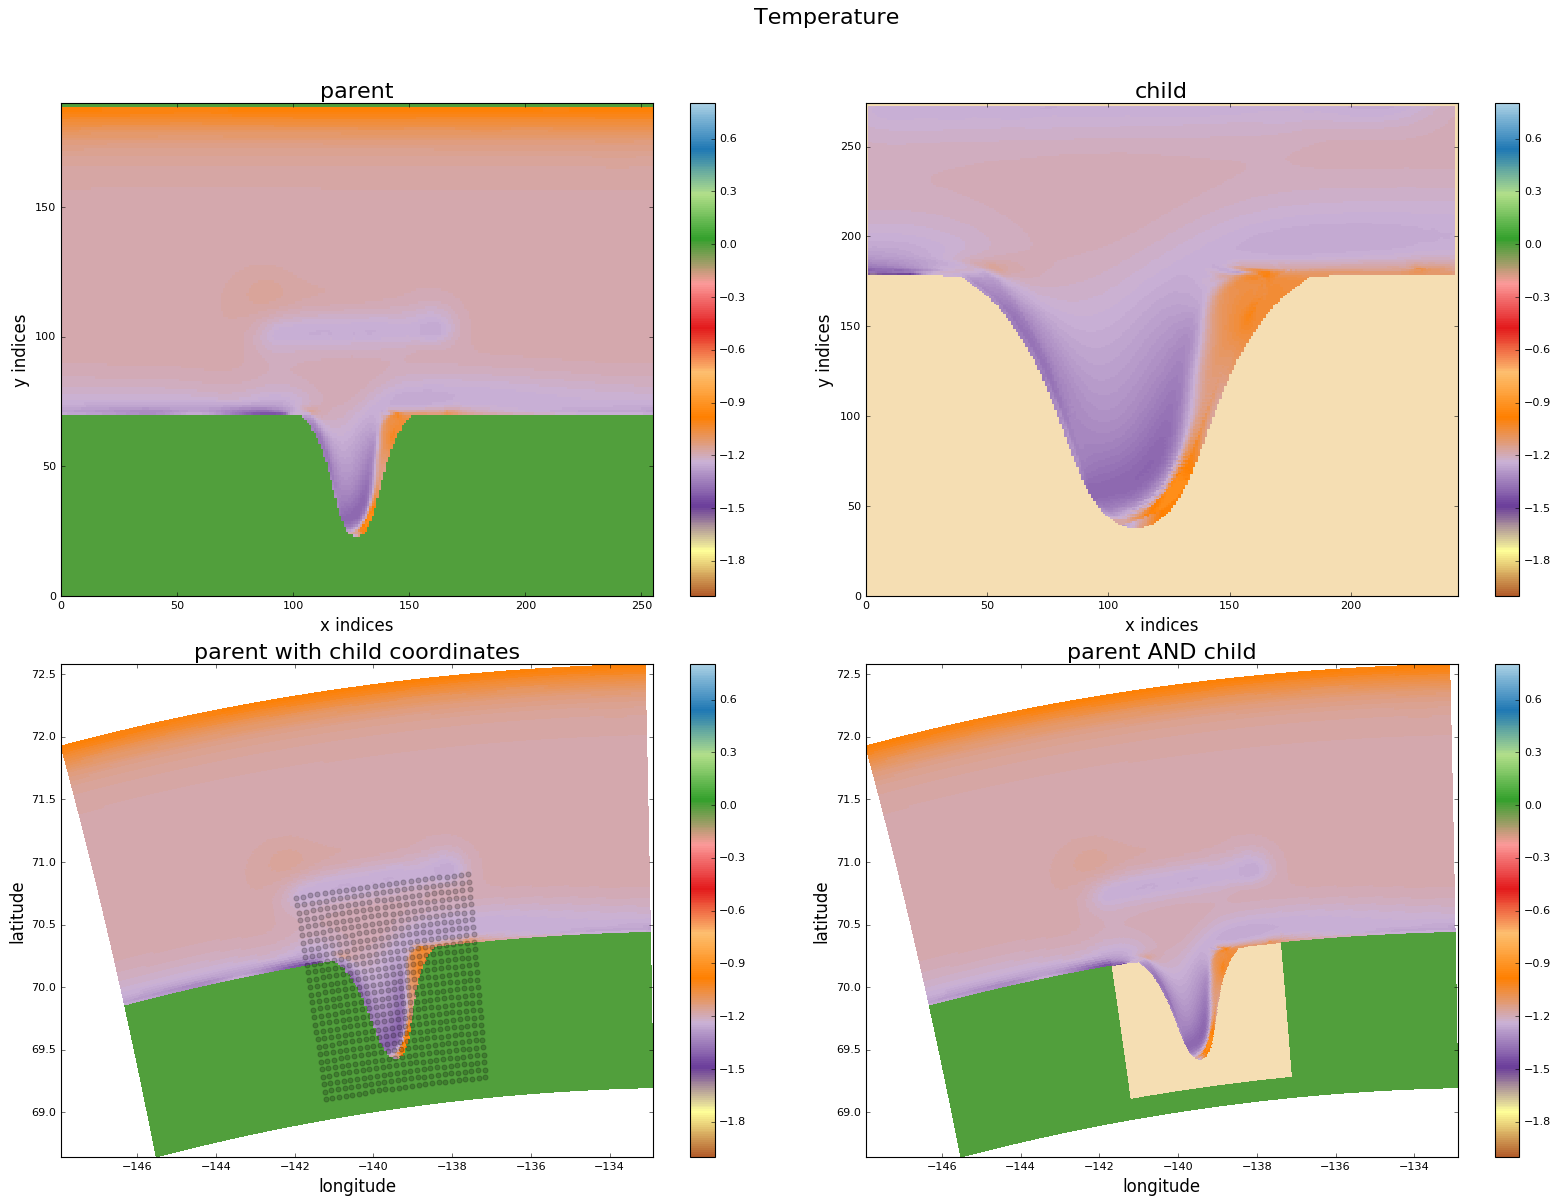

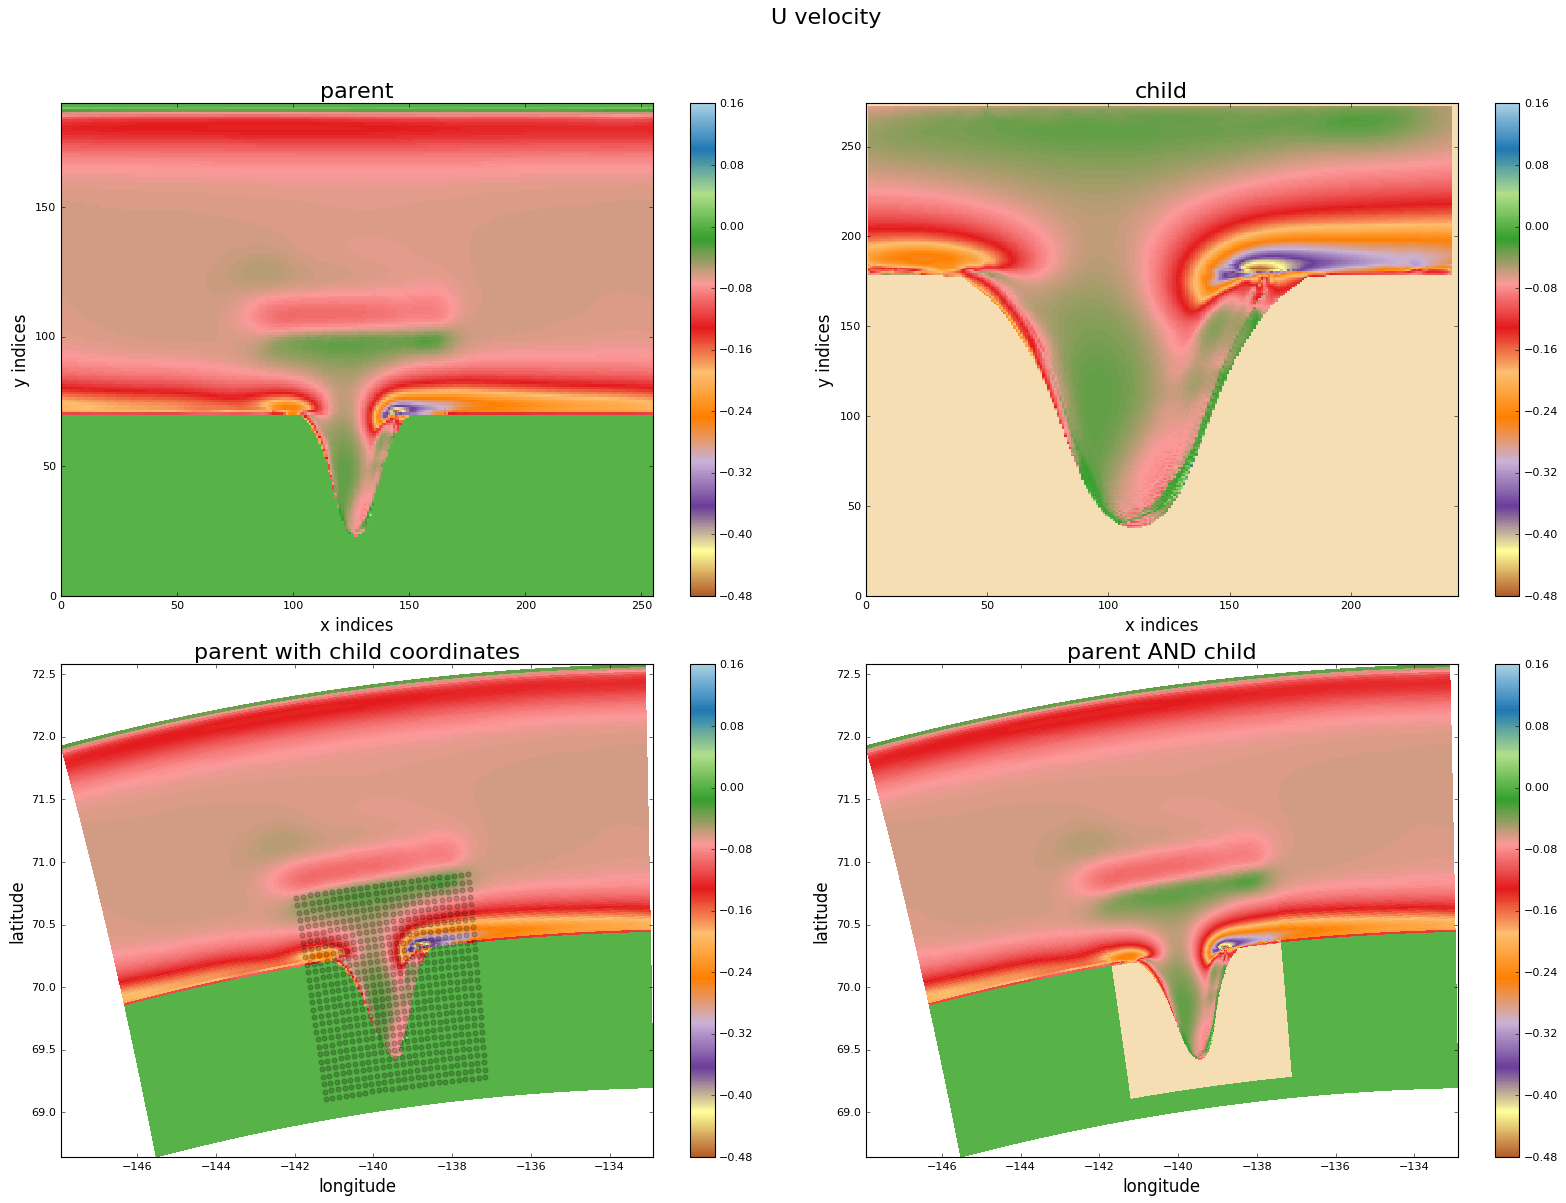

In [15]:
dirname='/home/mdunphy/Canyons/Results/Ideal4T2/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

ttl = 'Temperature'
figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -2.0, 0.8, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.48, 0.16, ttl)

### Real Surface

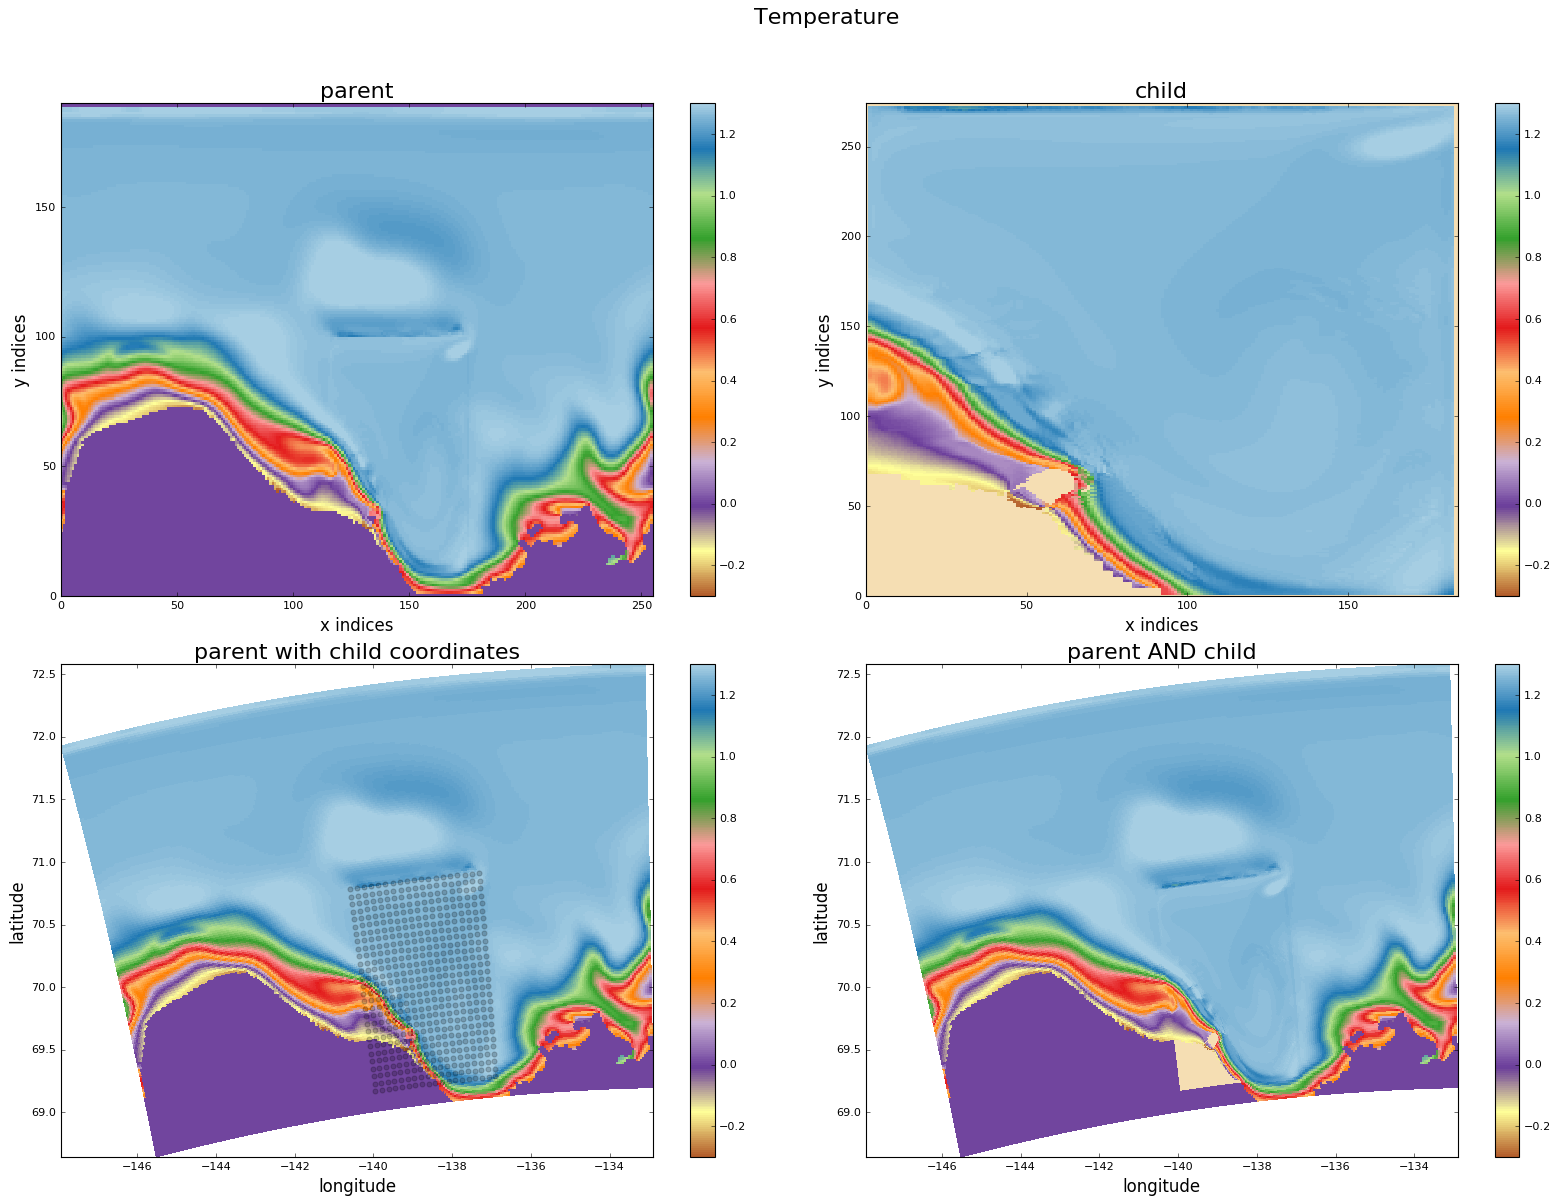

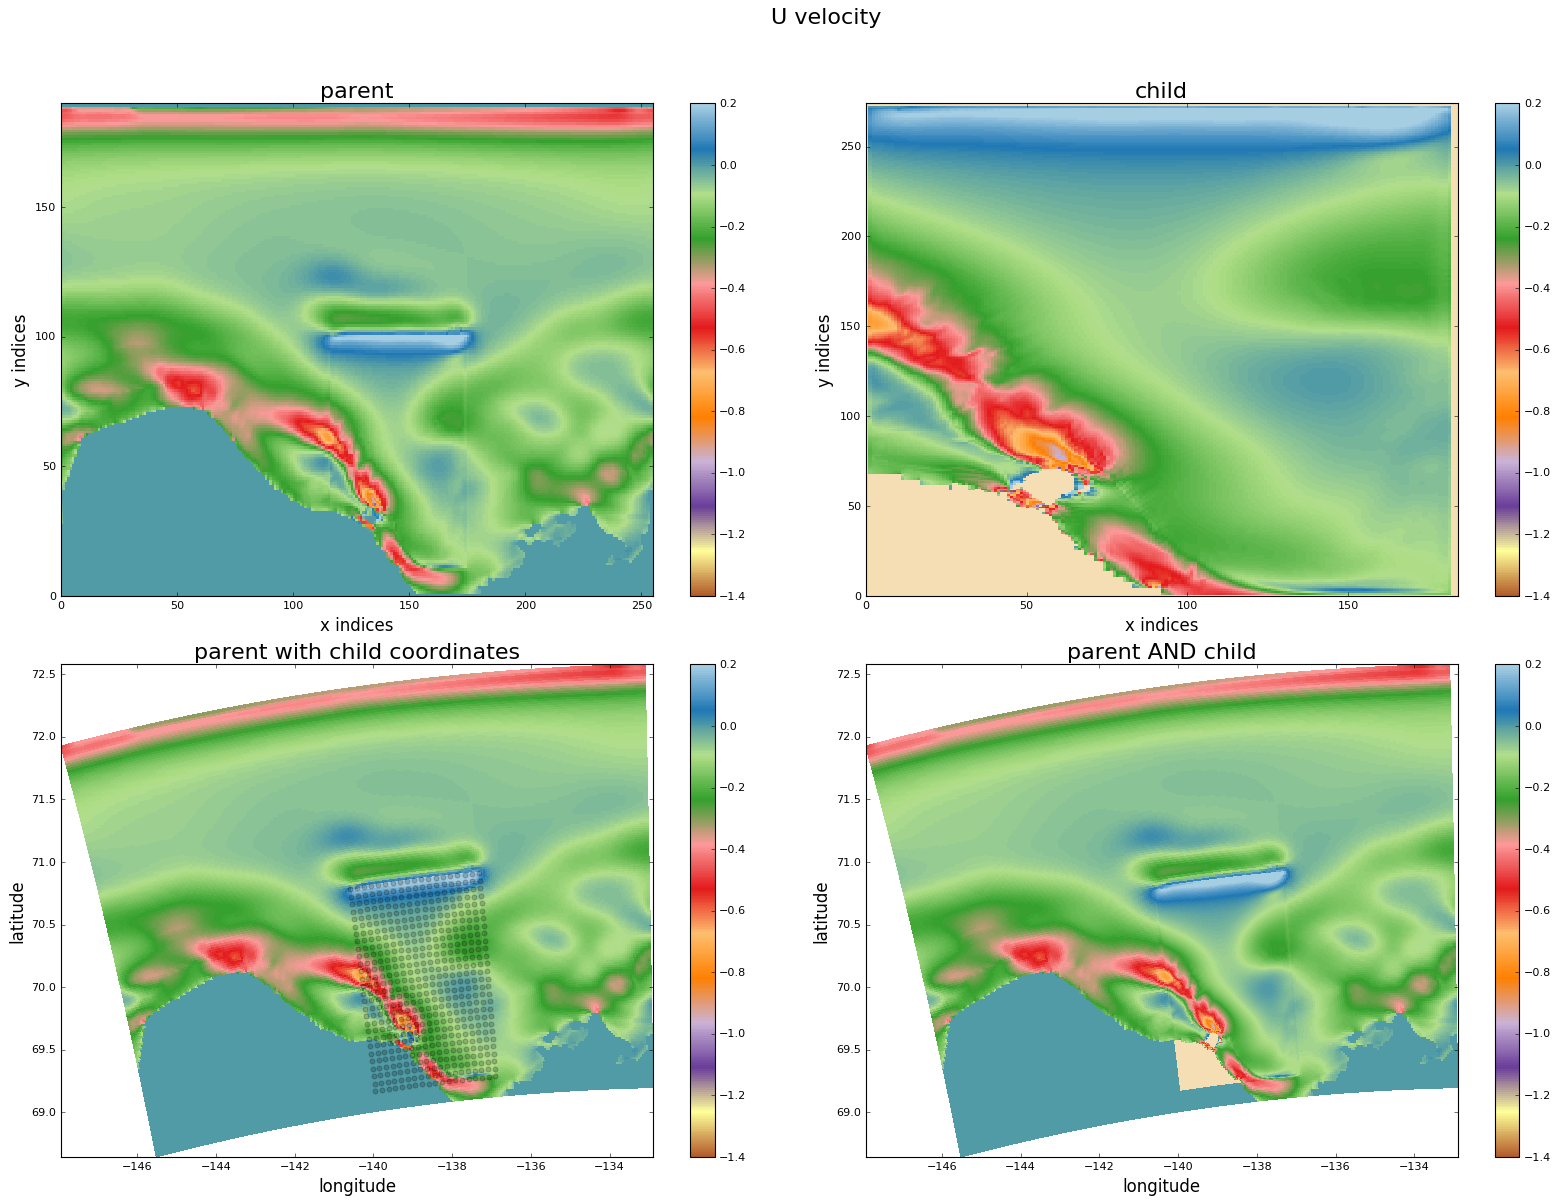

In [16]:
dirname='/home/mdunphy/Canyons/Results/Real4T2/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

ttl = 'Temperature'
figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 1.3, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.4, 0.2, ttl)

### Real Depth

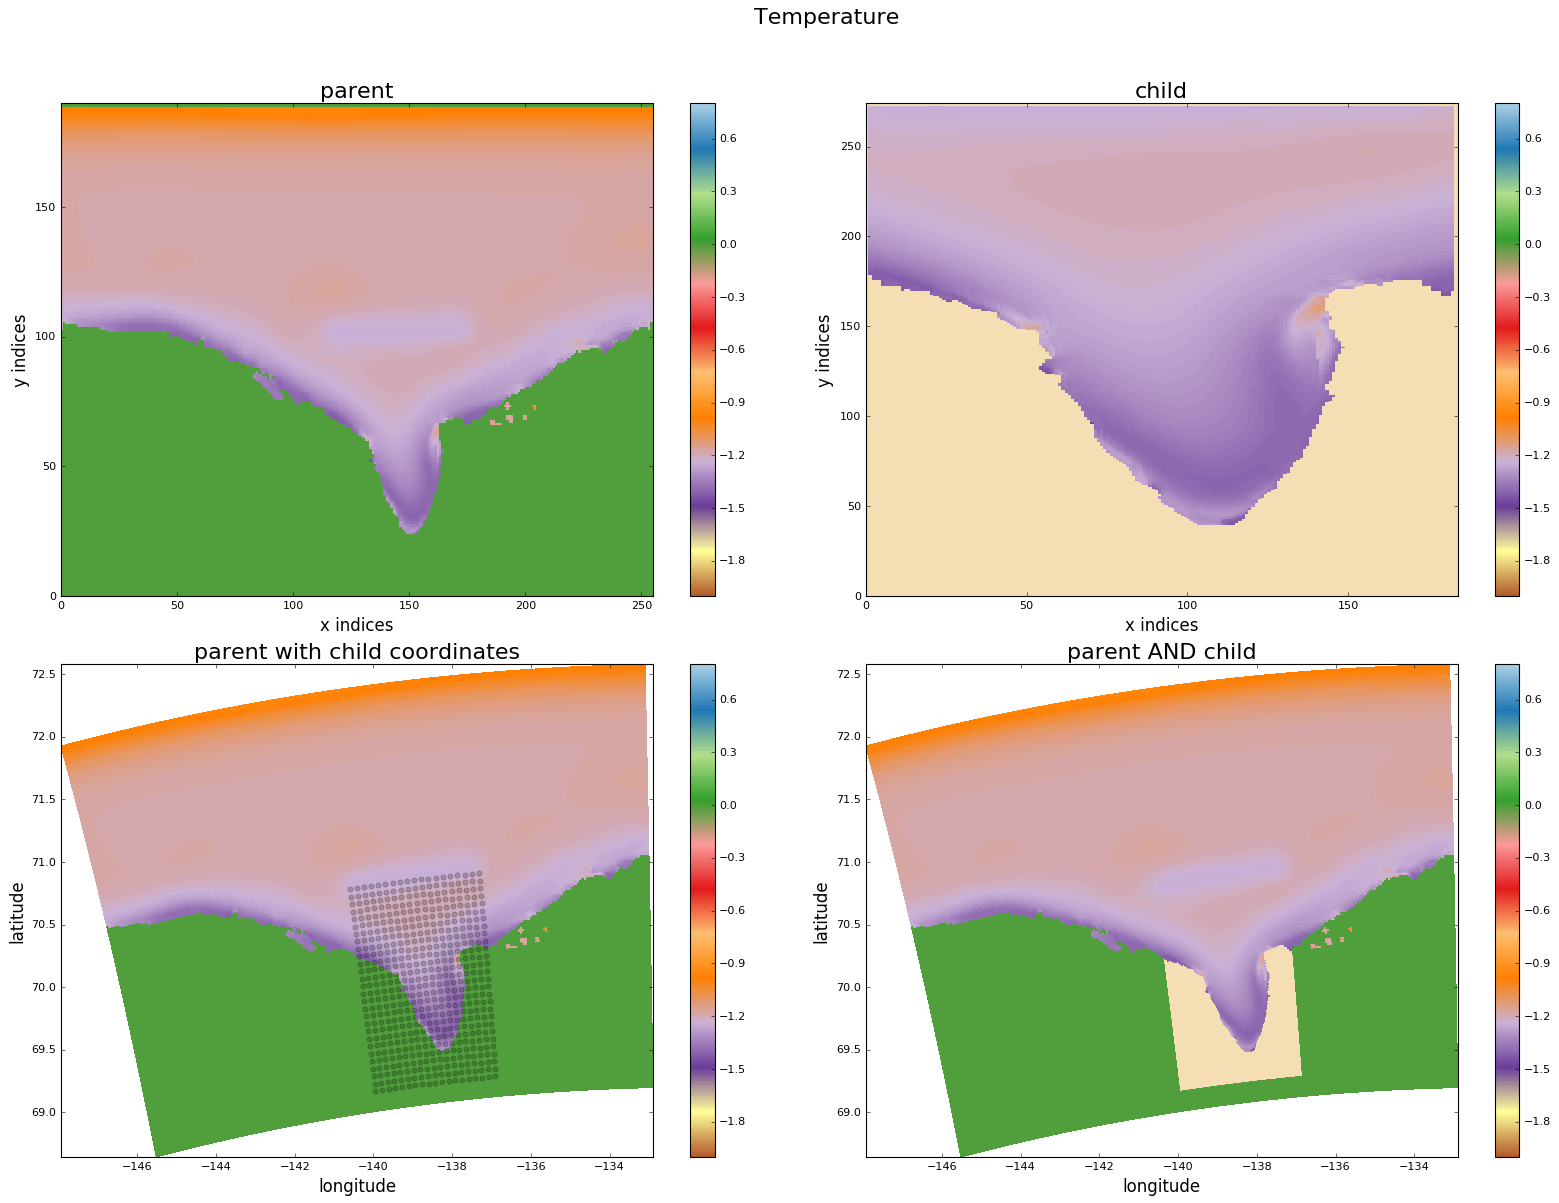

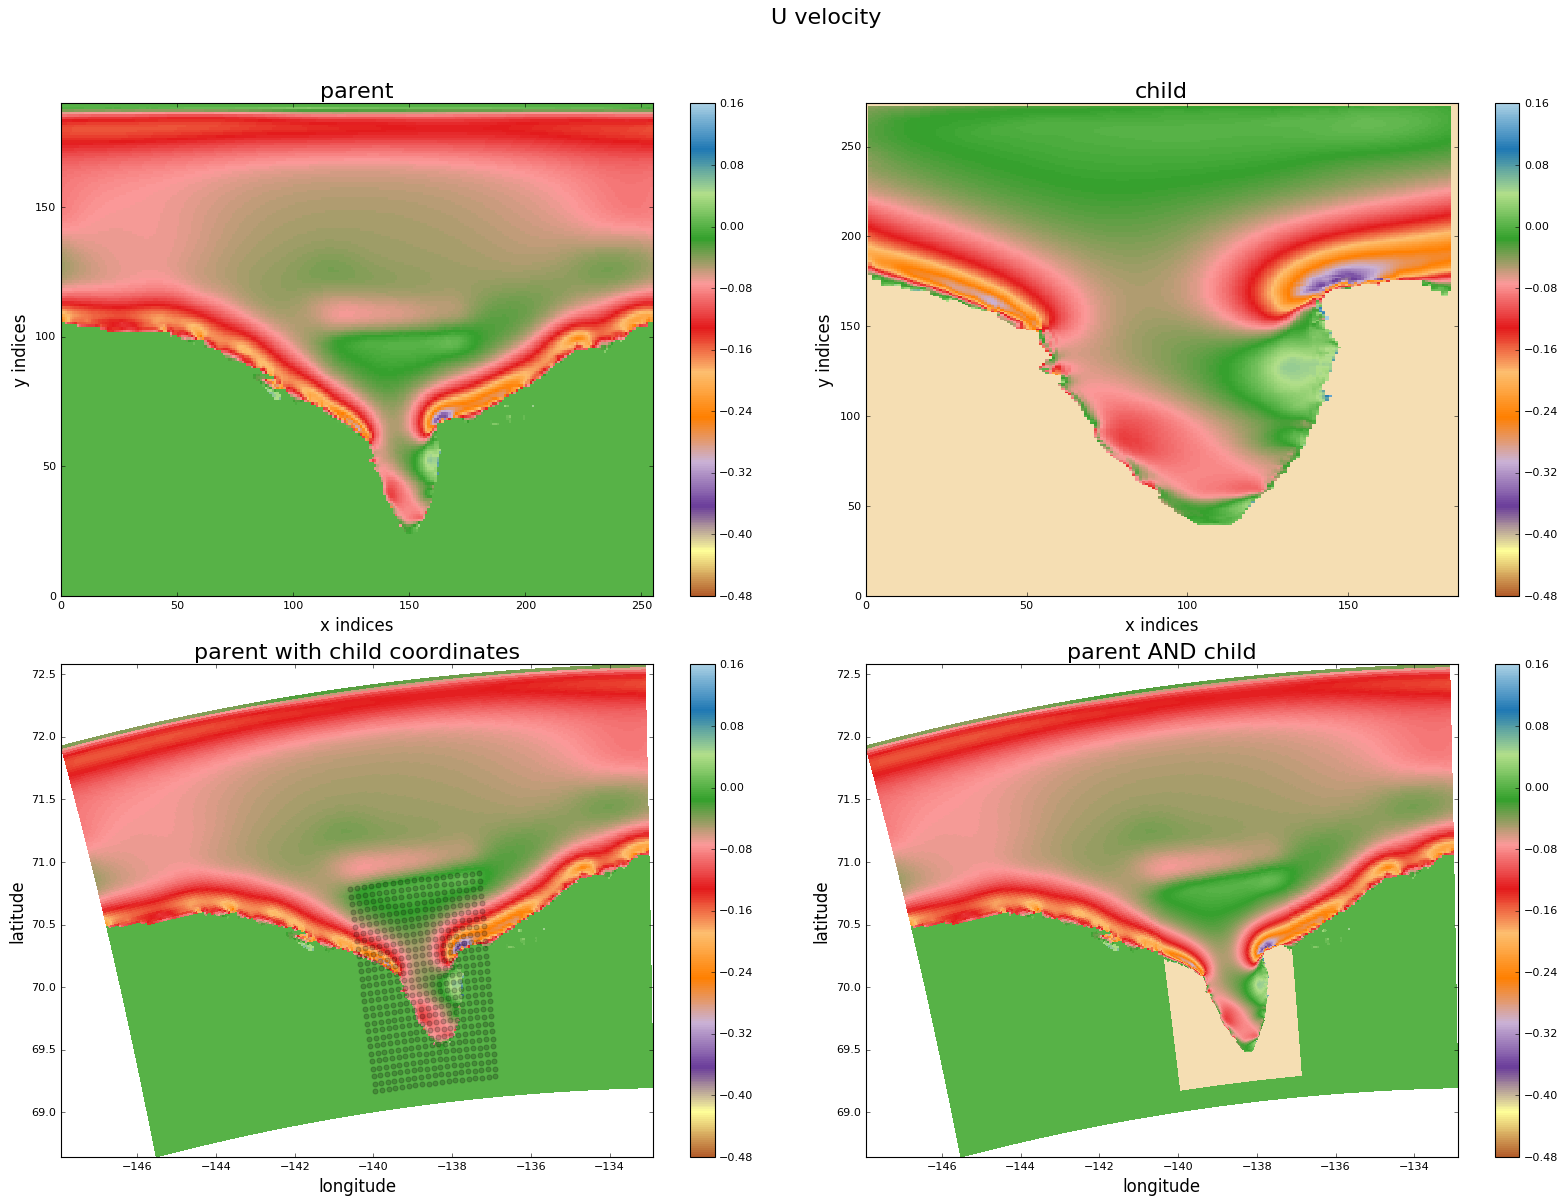

In [17]:
dirname='/home/mdunphy/Canyons/Results/Real4T2/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

ttl = 'Temperature'
figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -2.0, 0.8, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.48, 0.16, ttl)

# After fixing parent/child winds in sbcana

### 1. Surface

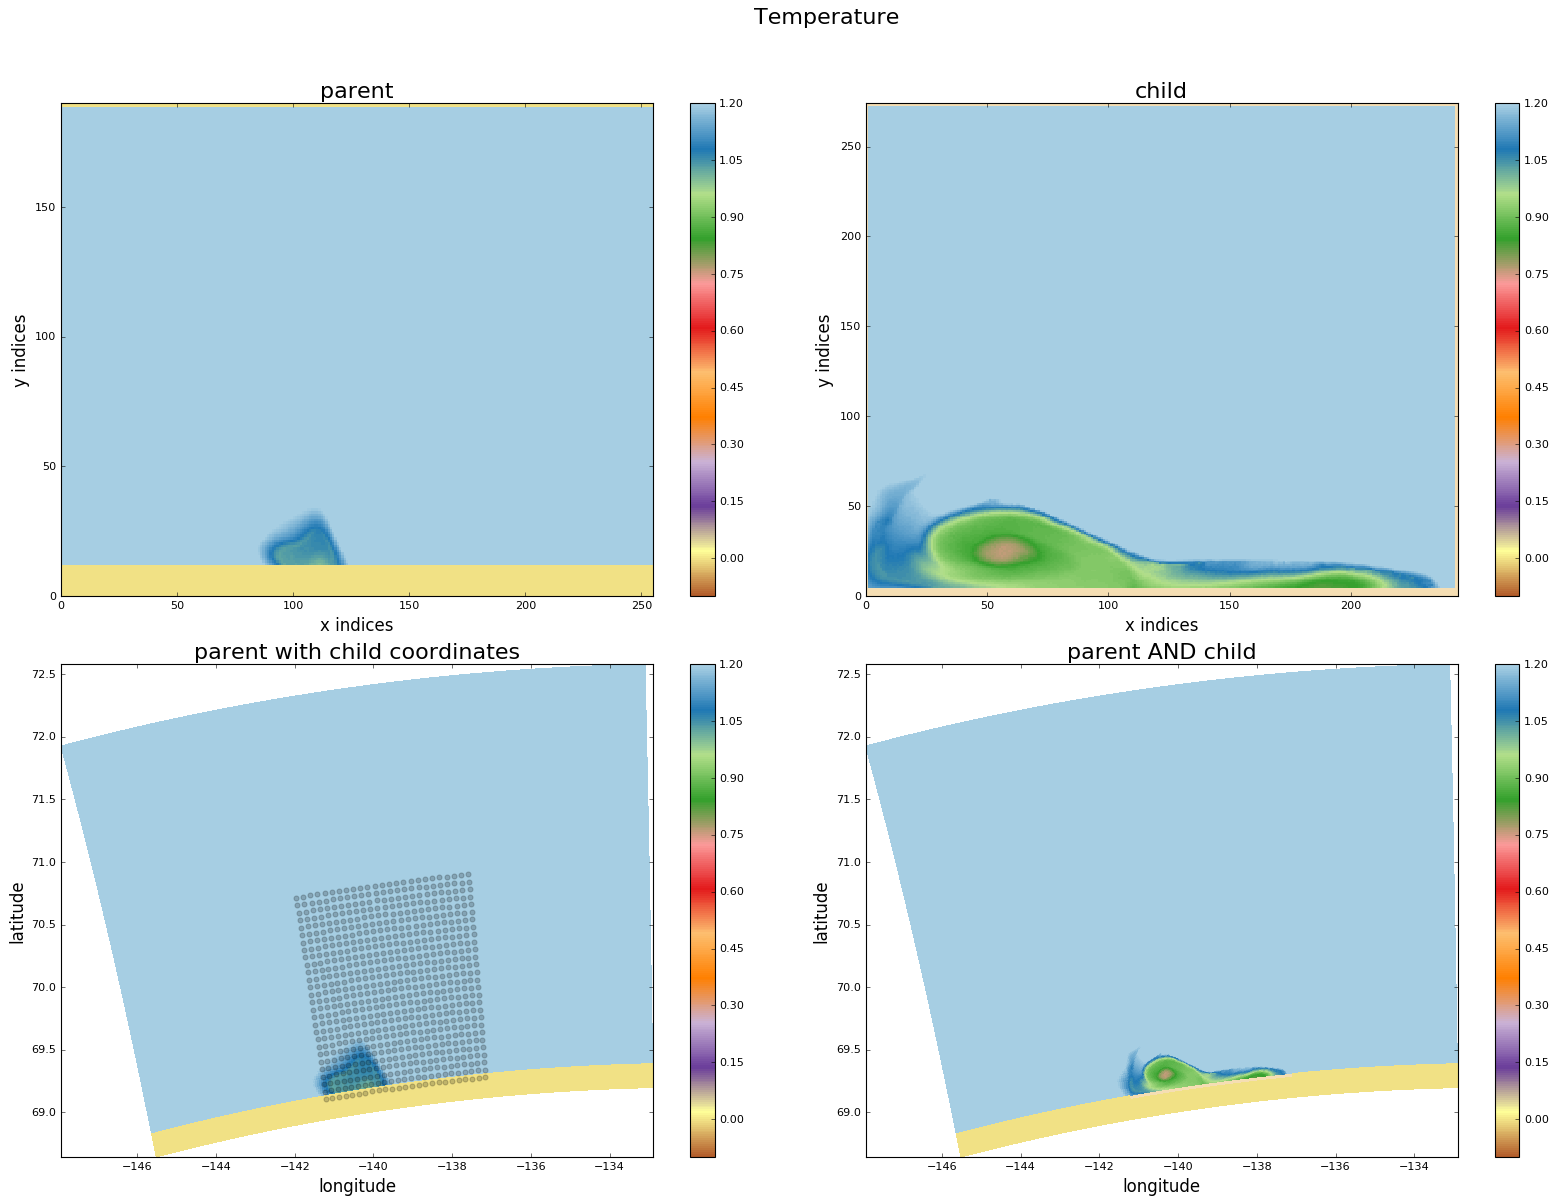

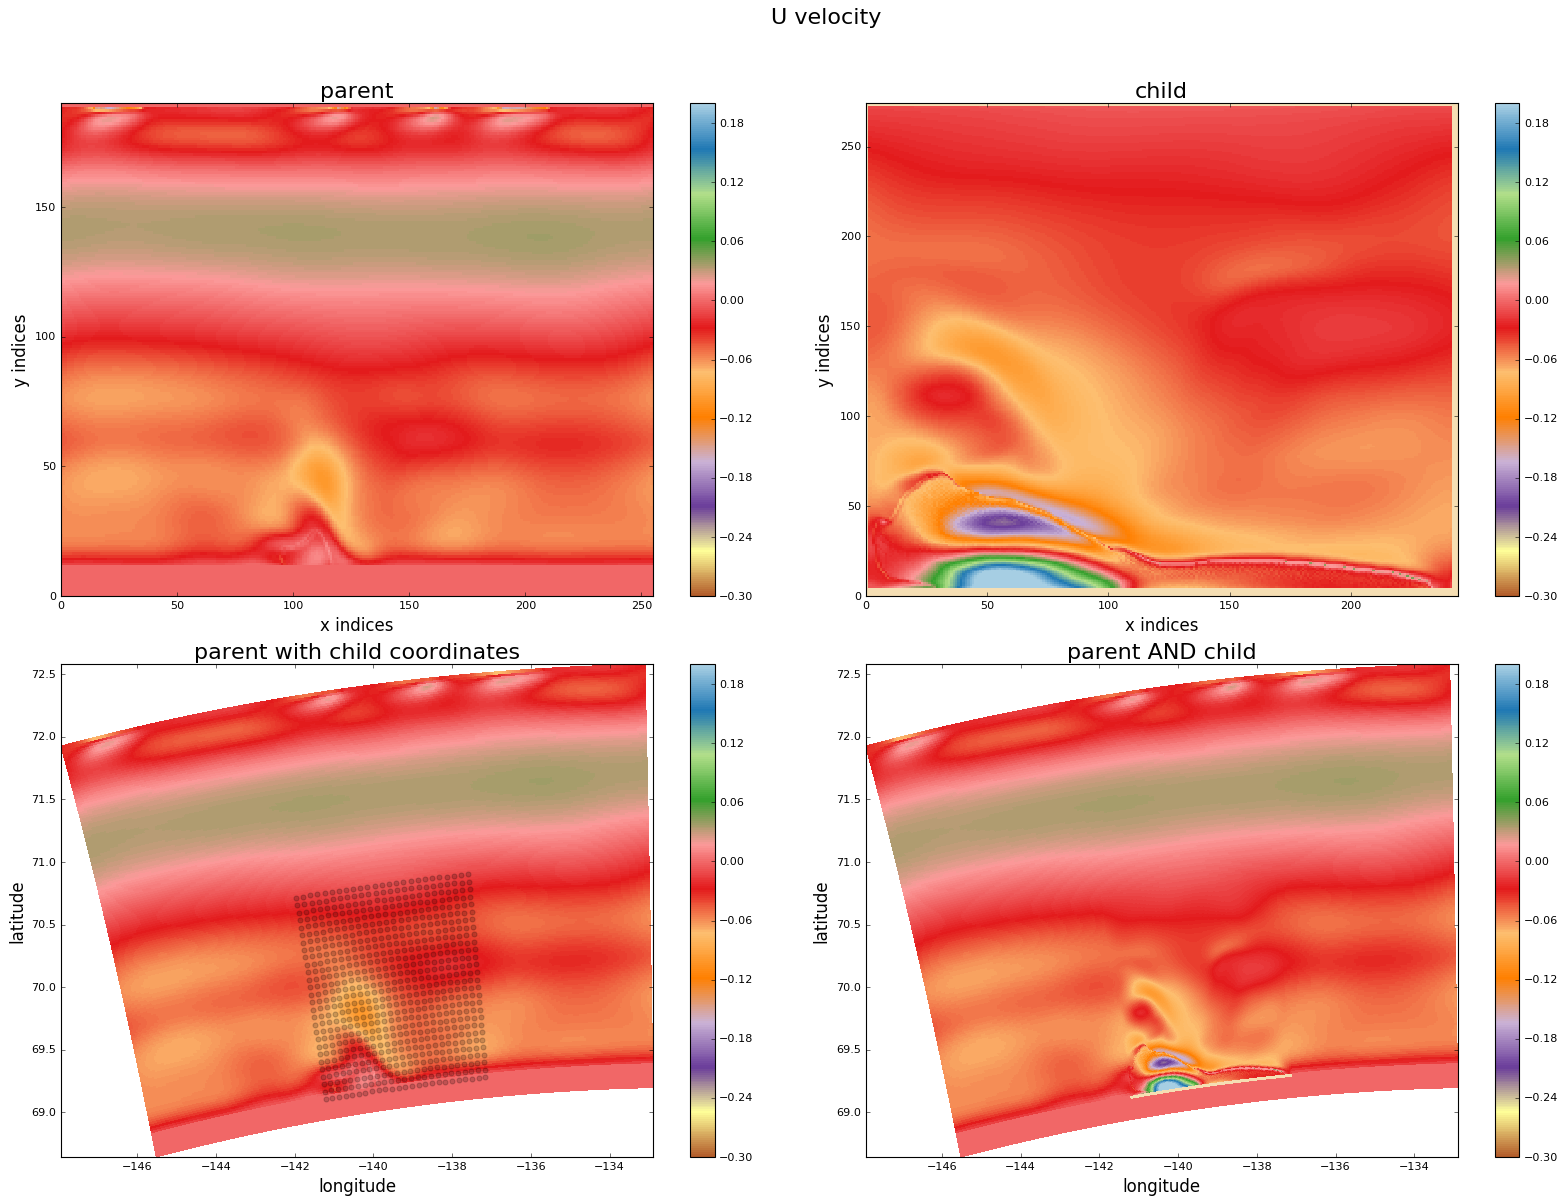

In [18]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 0
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

ttl = 'Temperature'
figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.1, 1.2, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.3, 0.2, ttl)

### 2. Depth

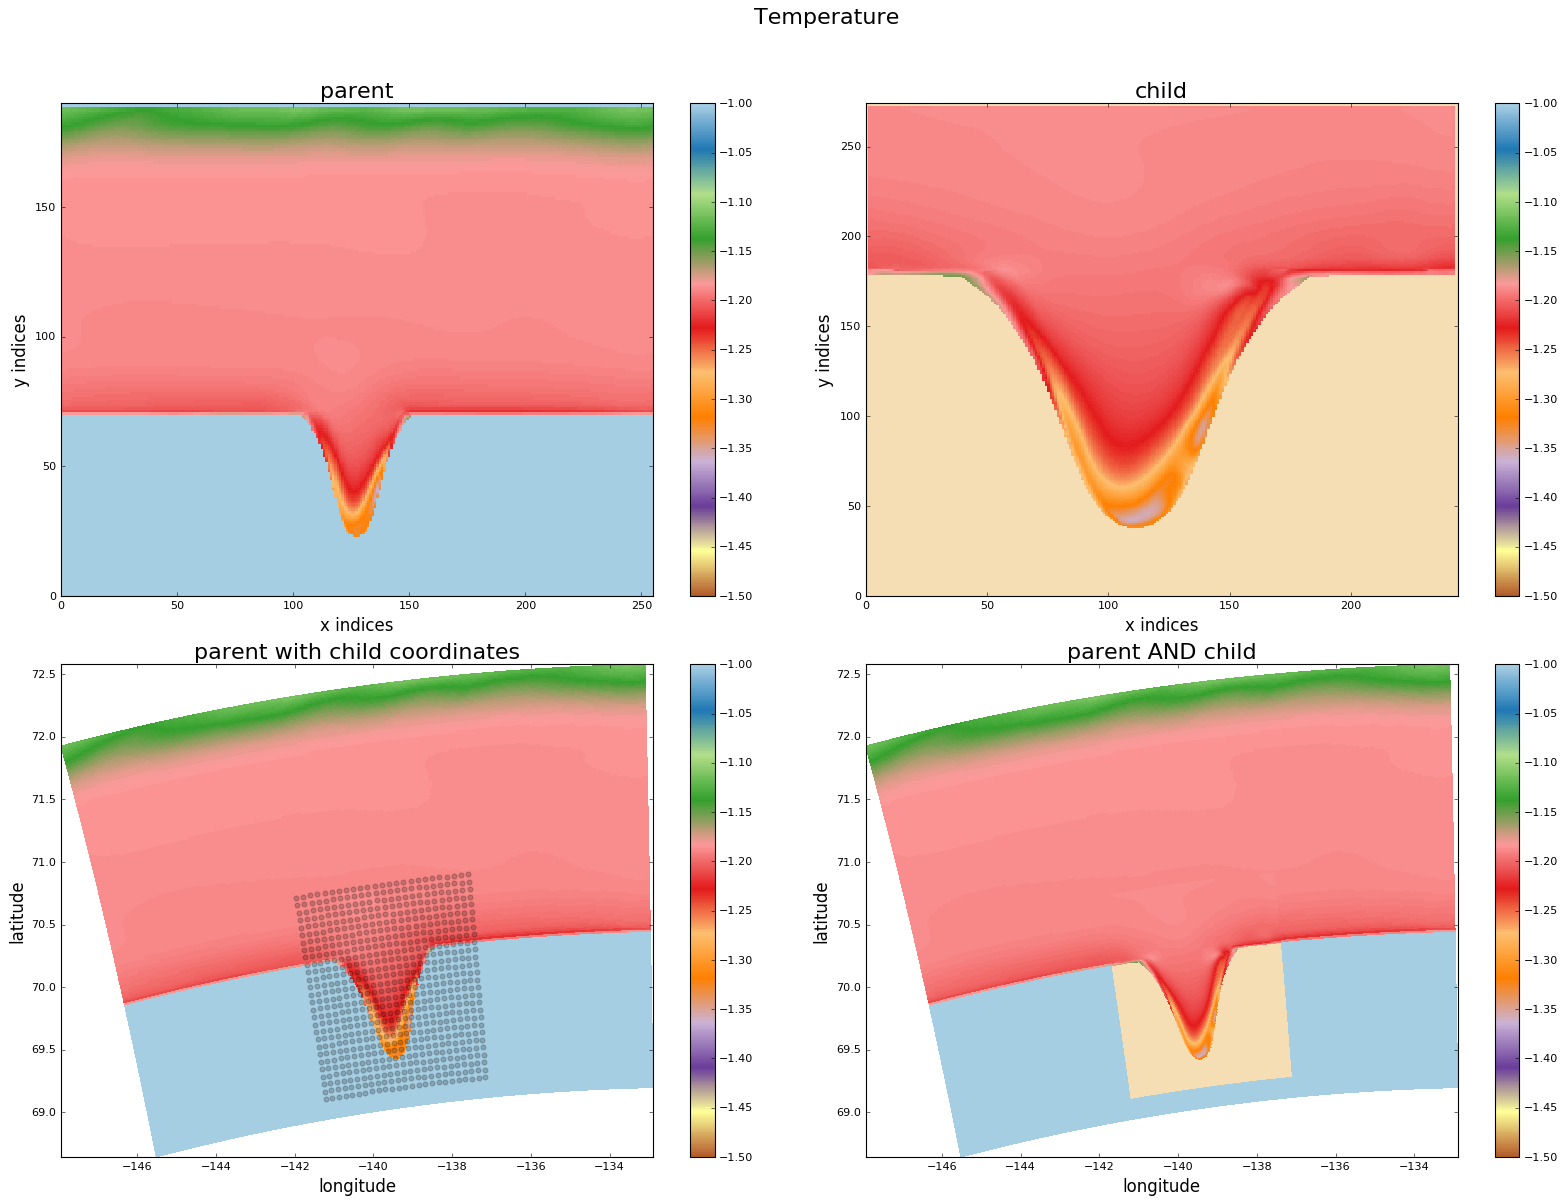

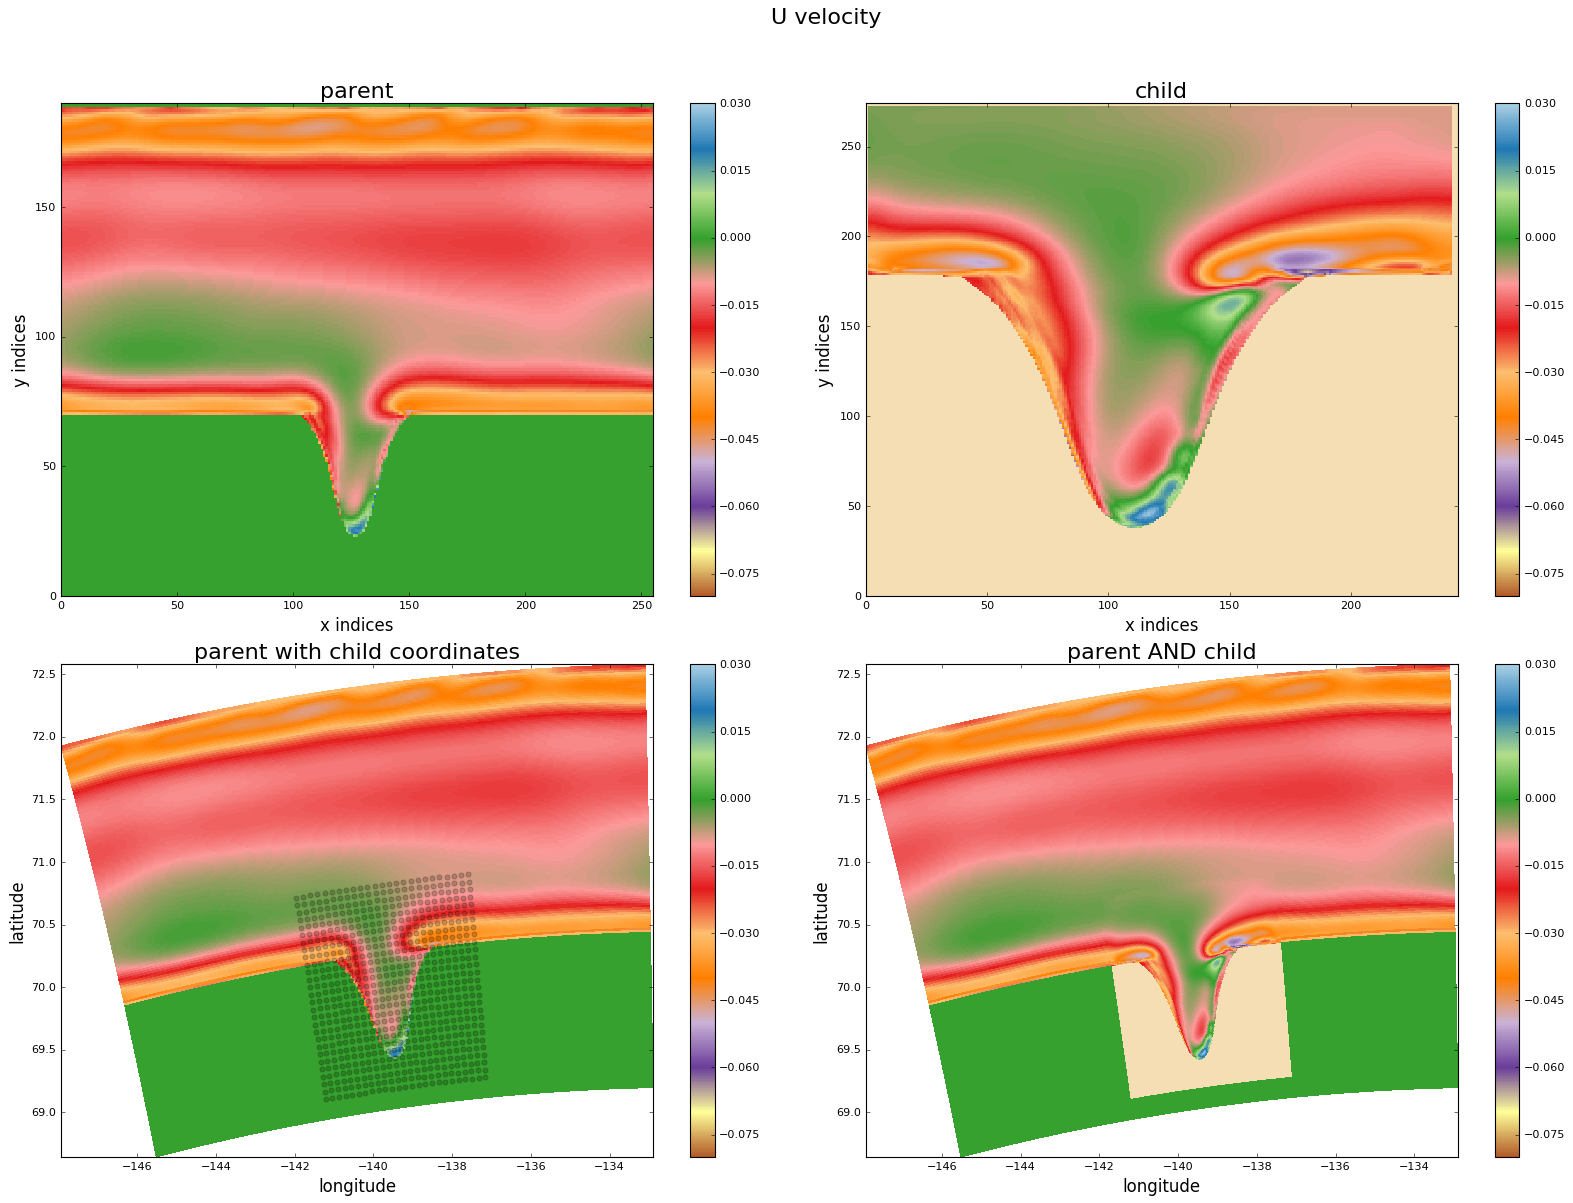

In [19]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filesTp = get_parent_files(dirname, 'grid_T')
filesTp.sort(key=os.path.basename)

filesUp = get_parent_files(dirname, 'grid_U')
filesUp.sort(key=os.path.basename)

filesTc = get_child_files(dirname, 'grid_T')
filesTc.sort(key=os.path.basename)

filesUc = get_child_files(dirname, 'grid_U')
filesUc.sort(key=os.path.basename)

dep_ind = 9
temp_parent, temp_child, u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child = get_variables(dep_ind, filesTp, filesUp, filesTc, filesUc)

ttl = 'Temperature'
figT =  make_plot(temp_parent, temp_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -1.5, -1.0, ttl)

ttl = 'U velocity'
figU =  make_plot(u_parent, u_child, nav_lon_parent, nav_lat_parent, nav_lon_child, nav_lat_child, -0.08, 0.03, ttl)